<!-- ![separator1](https://i.imgur.com/RQnsV0w.png) -->

![separator1](https://i.imgur.com/RQnsV0w.png)
# **<center>Model for Predicting Credit Card Customer Attrition** </center>

![separator1](https://i.imgur.com/RQnsV0w.png)

![alternatvie text](https://www.bankofbaroda.in/-/media/project/bob/countrywebsites/india/blogs/images/new-credit-card-rules-effective-from-july-1-2022.jpg)



<br><b>2023F-T3 BDM 3603 - Big Data Framework 01</b>
<br>Group Members:
<br>&emsp;&emsp;Jefford Secondes (c0865112)
<br>&emsp;&emsp;Maricris Resma (c0872252)
<br>&emsp;&emsp;Jovi Fez Bartolata (c0869701)
<br>&emsp;&emsp;Luz Zapanta (c0879190)
<br>&emsp;&emsp;Keyvan Amini (c0866360)



--------------------
</center>

**PROJECT DESCRIPTION:**

The goal of this project is to create a model that can accurately predict when a credit card company will lose a customer. The other goal of this activity is to find the main reasons why clients leave and give you useful information to help you keep clients. The work will include gathering data, cleaning it up, analyzing it, choosing which features to use, and building a model using machine learning techniques.

High customer turnover rates hurt a business's bottom line, so keeping customers and lowering churn rates are important for making more money. Through this project, the company will be able to find customers who are likely to leave and create targeted, preventative campaigns to keep those customers.

**OBJECTIVES:**
1. Identify early indicators of credit card attrition based on customer profile and spend behaviour
2. Build a predictive model to identify and segment customers based on attrition risk

![separator1](https://i.imgur.com/RQnsV0w.png)


<font face='Tahoma' color='Yellow' size='5'><b> DATA HANDLING

In [275]:
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType
import seaborn as sns
from pyspark.ml.evaluation import *
import pandas as pd
import matplotlib.pyplot as plt

In [276]:
# Create a Spark session
spark = SparkSession.builder.appName("CreditCardAttrition").getOrCreate()

<font face='Tahoma' color='Yellow' size='4'> Importing dataset 

In [277]:
# reading the data
df = spark.read.csv("creditcardattritiondata.csv", header=True, inferSchema=True)

<font face='Tahoma' color='yellow'> df.describe() </font>When you use the describe method on a df DataFrame, it gives you a summary of the shape, central tendency, and dispersion of a set of continuous variables. The count, mean, standard deviation, minimum, 25th percentile, median (50th percentile), 75th percentile, and maximum of each column in the DataFrame will be shown in the output. <br>
<font face='Tahoma' color='yellow'>  show()</font> method is used to display the results.<br><br>
<font face='Tahoma' color='yellow'> Count: </font> The number of non-null values.<br>
<font face='Tahoma' color='yellow'> Mean: </font>The average value.<br>
<font face='Tahoma' color='yellow'> Standard Deviation:</font> A measure of the amount of variation or dispersion.<br>
<font face='Tahoma' color='yellow'> Min:</font> The minimum value.<br>
<font face='Tahoma' color='yellow'>25th Percentile (First Quartile): </font>The value below which 25% of the data falls.<br>
<font face='Tahoma' color='yellow'> 50th Percentile (Median):</font> The middle value of the data.<br>
<font face='Tahoma' color='yellow'> 75th Percentile (Third Quartile):</font> The value below which 75% of the data falls.<br>
<font face='Tahoma' color='yellow'> Max:</font> The maximum value.<br>

<font face='Tahoma' color='Yellow'> Plot the data using MATPLOTLIB before preprocessing step

+-----------------+-----+
|   Attrition_flag|count|
+-----------------+-----+
|Existing Customer| 8500|
|Attrited Customer| 1627|
+-----------------+-----+



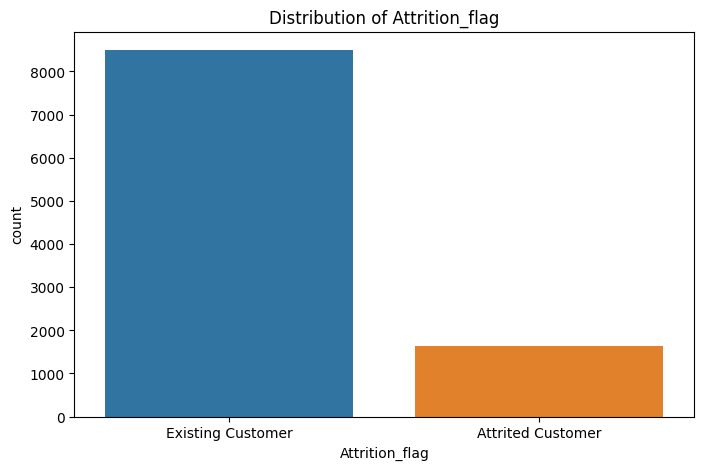

In [278]:
# Assuming your target variable is called 'Attrition' (change it accordingly)
target_variable = 'Attrition_flag'

# Check the distribution of the target variable
df.groupBy(target_variable).count().show()

# Convert the Spark DataFrame to a Pandas DataFrame for easier plotting
pd_df = df.select(target_variable).toPandas()

# Plot the distribution of the target variable using matplotlib
plt.figure(figsize=(8, 5))
sns.countplot(x=target_variable, data=pd_df)
plt.title('Distribution of {}'.format(target_variable))
plt.show()

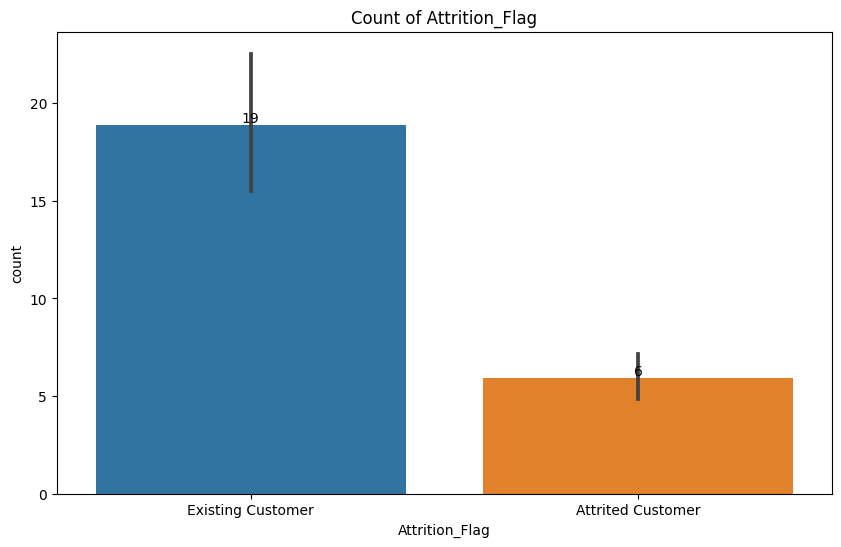

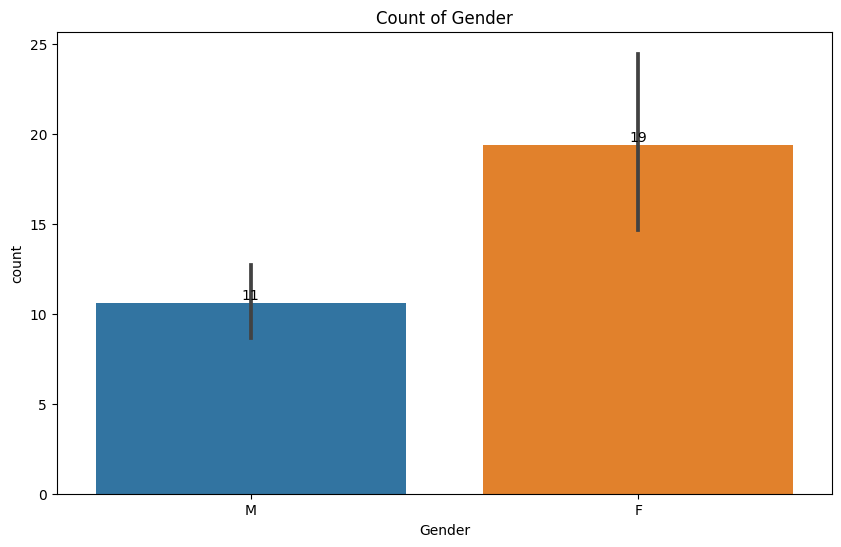

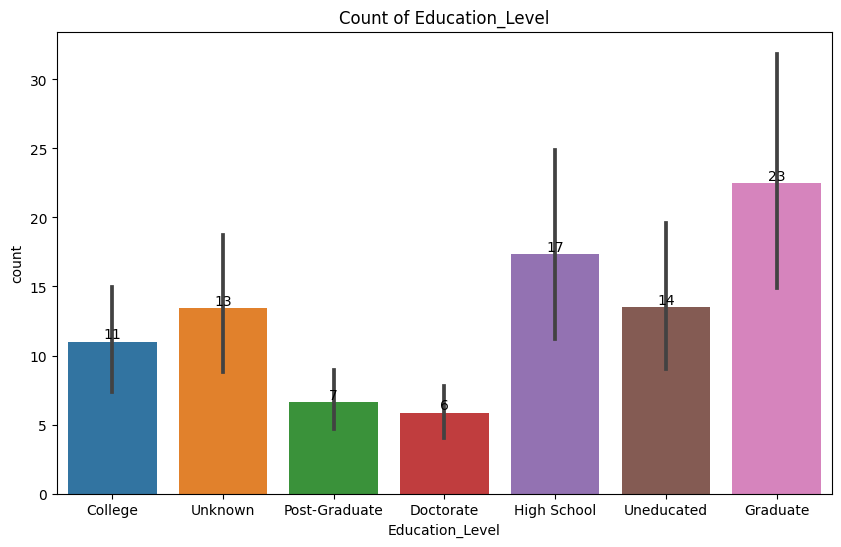

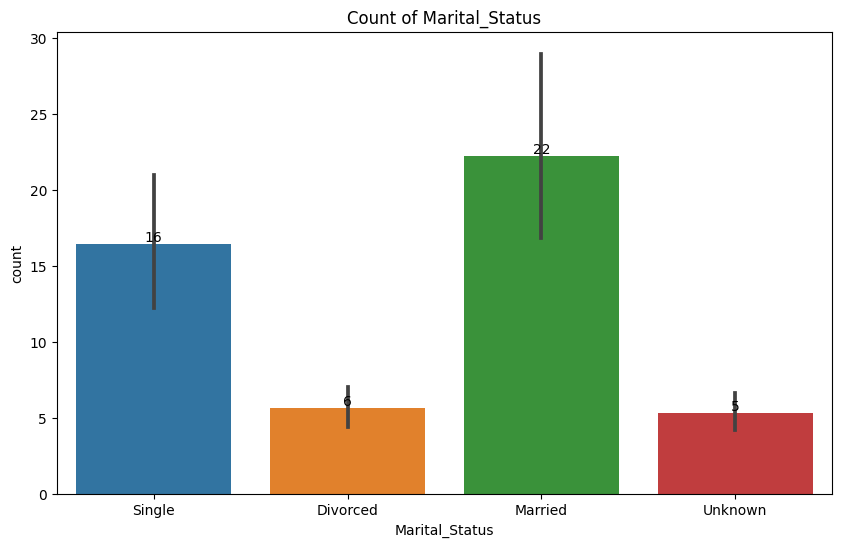

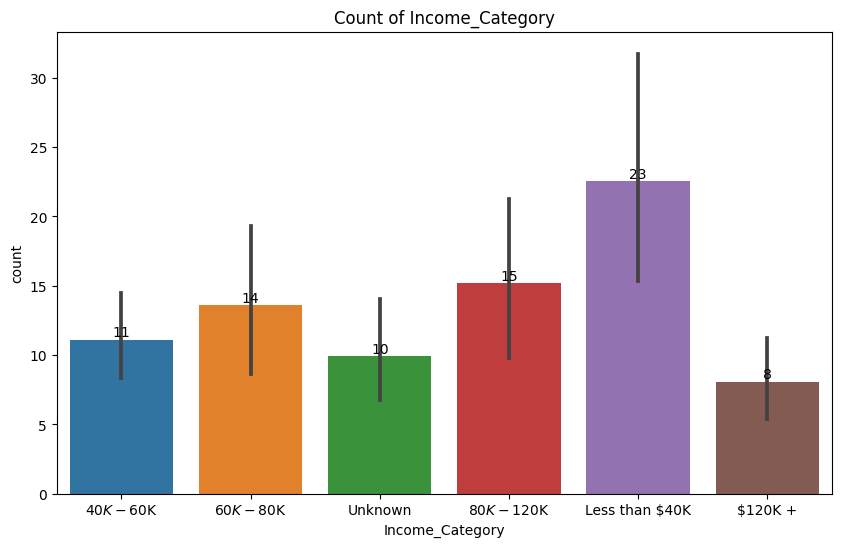

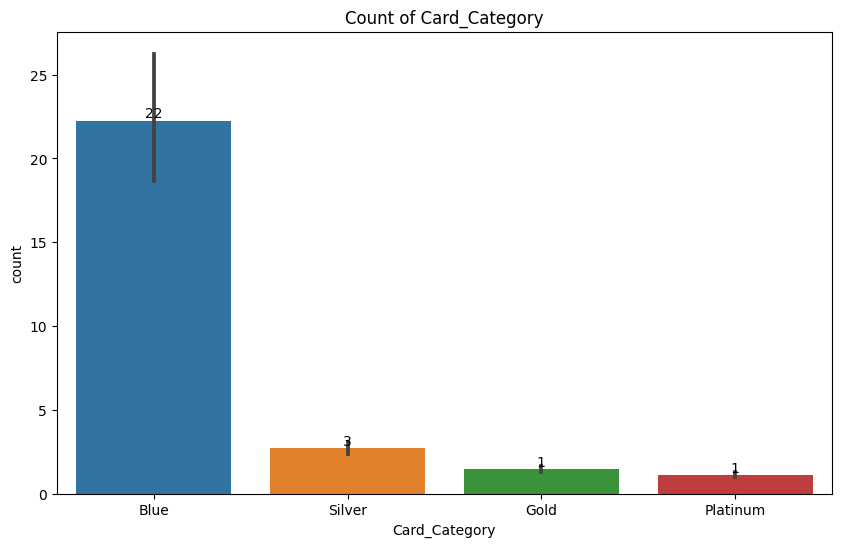

In [279]:
# Specify categorical columns
categorical_columns = ['Attrition_Flag', 'Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']

# Create a DataFrame containing the count of each unique value in each categorical column
histogram_data = df.groupBy(*categorical_columns).count().toPandas()

# Plot a bar chart for each categorical column
for column in categorical_columns:
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=column, y="count", data=histogram_data)
    plt.title(f'Count of {column}')

    # Add numerical values on top of the bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

    plt.show()

In [280]:
# Identify categorical and numerical features
categorical_features = []
numerical_features = []

for column, data_type in df.dtypes:
    if data_type == 'string':
        categorical_features.append(column)
    else:
        numerical_features.append(column)

# Print the identified features
print(f"Categorical Features: {categorical_features}")
print(f"Numerical Features: {numerical_features}")

Categorical Features: ['Attrition_Flag', 'Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']
Numerical Features: ['CLIENTNUM', 'Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2']


<font face='Tahoma' color='Yellow' size='5'><b> DATA PREPROCESSING

<font color='yellow'>Describe the data

In [281]:
#You can use the describe() function on a DataFrame (df) to get basic statistics for the numerical columns. This function gives you an overview of the central tendency, dispersion, and shape of the distribution of the numerical columns in a DataFrame.
df.describe().show()

+-------+-------------------+-----------------+-----------------+------+------------------+---------------+--------------+---------------+-------------+------------------+------------------------+----------------------+---------------------+-----------------+-------------------+-----------------+--------------------+-----------------+-----------------+-------------------+---------------------+----------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------+
|summary|          CLIENTNUM|   Attrition_Flag|     Customer_Age|Gender|   Dependent_count|Education_Level|Marital_Status|Income_Category|Card_Category|    Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|     Credit_Limit|Total_Revolving_Bal|  Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|  Total_Trans_Amt|   To

**Observations:** <font face='Tahoma' color='Yellow' size='2'><b>  </font> 
<font face='yellow' color='Yellow'> 
- The raw data has 10,127 observations/rows and 23 variables/columns.
- Y Variable / Dependent Variable is <b>Attrition_Flag</b>
- X Variable / Independent Variables will be taken from the other 22 variables 

<font color='yellow'>Number of columns and rows <br>
<font color='Yellow'>Dimensions of data <br>
<font color='Yellow'>Handle any missing or duplicate data <br>

**Observations:**
- No feature has null or nan values
- No duplicate records
- Education_Level, Marital_Status and Income_Category have 'Unknown' data as value

In [282]:
# Handling missing data: Drop rows with any missing values
df = df.dropna()

# Handling duplicate data: Drop duplicate rows
df = df.dropDuplicates()

# Show the cleaned DataFrame
df.show(5)

column_count = len(df.columns) ## count the number of columns
row_count = df.count()  ## count the number of rows
print (f"Number of columns: {column_count}")
print(f"Number of rows: {row_count}")



+---------+-----------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+----------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------+
|CLIENTNUM|   Attrition_Flag|Customer_Age|Gender|Dependent_count|Education_Level|Marital_Status|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|Naive_Bayes_Classifier_Attrit

In [283]:
df.show(5)

+---------+-----------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+----------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------+
|CLIENTNUM|   Attrition_Flag|Customer_Age|Gender|Dependent_count|Education_Level|Marital_Status|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|Naive_Bayes_Classifier_Attrit

In [284]:
# showing last 5 rows
last_5_rows = df.toPandas().tail(5)

# Display the last 5 rows
print(last_5_rows)

       CLIENTNUM     Attrition_Flag  Customer_Age Gender  Dependent_count  \
10122  711339258  Existing Customer            49      F                3   
10123  711465333  Existing Customer            35      M                4   
10124  712438308  Existing Customer            27      F                1   
10125  717774333  Attrited Customer            48      M                3   
10126  778745058  Existing Customer            50      M                3   

      Education_Level Marital_Status Income_Category Card_Category  \
10122        Graduate         Single     $40K - $60K        Silver   
10123     High School         Single    $80K - $120K          Blue   
10124     High School        Married         Unknown          Blue   
10125     High School        Married     $60K - $80K          Blue   
10126     High School         Single    $80K - $120K        Silver   

       Months_on_book  ...  Credit_Limit  Total_Revolving_Bal  \
10122              36  ...       20176.0           

In [285]:
df.columns # showing columns

['CLIENTNUM',
 'Attrition_Flag',
 'Customer_Age',
 'Gender',
 'Dependent_count',
 'Education_Level',
 'Marital_Status',
 'Income_Category',
 'Card_Category',
 'Months_on_book',
 'Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Credit_Limit',
 'Total_Revolving_Bal',
 'Avg_Open_To_Buy',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Amt',
 'Total_Trans_Ct',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio',
 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2']

In [286]:
print("DataFrame Schema:")
df.printSchema()   # Printscema showing columns with what kind of datatypes

DataFrame Schema:
root
 |-- CLIENTNUM: integer (nullable = true)
 |-- Attrition_Flag: string (nullable = true)
 |-- Customer_Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Dependent_count: integer (nullable = true)
 |-- Education_Level: string (nullable = true)
 |-- Marital_Status: string (nullable = true)
 |-- Income_Category: string (nullable = true)
 |-- Card_Category: string (nullable = true)
 |-- Months_on_book: integer (nullable = true)
 |-- Total_Relationship_Count: integer (nullable = true)
 |-- Months_Inactive_12_mon: integer (nullable = true)
 |-- Contacts_Count_12_mon: integer (nullable = true)
 |-- Credit_Limit: double (nullable = true)
 |-- Total_Revolving_Bal: integer (nullable = true)
 |-- Avg_Open_To_Buy: double (nullable = true)
 |-- Total_Amt_Chng_Q4_Q1: double (nullable = true)
 |-- Total_Trans_Amt: integer (nullable = true)
 |-- Total_Trans_Ct: integer (nullable = true)
 |-- Total_Ct_Chng_Q4_Q1: double (nullable = true)
 |-- Avg_Utilizatio

<font face='Tahoma' color='yellow'> columns_to_drop </font> is created, containing the names of the columns that you want to remove from the DataFrame. In this case, it includes two columns: 'CLIENTNUM' and a long column name starting with 'Naive_Bayes_Classifier'. <br>
<font face='Tahoma' color='yellow'>df = df.drop(*columns_to_drop) </font> The drop method is used to remove the specified columns from the DataFrame (df). The *columns_to_drop syntax is used to unpack the list of column names so that they are treated as individual arguments to the drop method.

In [287]:
# List of columns to drop
columns_to_drop = ['CLIENTNUM','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 
                   'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2']

# Drop the specified columns
df = df.drop(*columns_to_drop)

# Show the updated DataFrame
df.show(5)

+-----------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+
|   Attrition_Flag|Customer_Age|Gender|Dependent_count|Education_Level|Marital_Status|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|
+-----------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+--------

In this dictionary <font face='Tahoma' color='yellow'> (columns_mapping) </font>, old column names are mapped to their corresponding new column names. Each key-value pair represents an old column name and the desired new column name. <br> This loop iterates through the items of the columns_mapping dictionary. 
For each pair, it uses the withColumnRenamed method to rename the old column to the new column in the DataFrame (df). 
This is an in-place operation that updates the DataFrame with the new column names.
<font face='Tahoma' color='yellow'><br> for old_col, new_col in columns_mapping.items():<br>
    df = df.withColumnRenamed(old_col, new_col) </font>

In [288]:
# Rename the specified columns, Create a dictionary mapping old column names to new column names:
columns_mapping = {
    'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1': 'Churn_Prob',
    'Months_on_book': 'Months',
    'Total_Relationship_Count': 'Relations',
    'Dependent_count': 'Dependents',
    'Customer_Age': 'Age',
    'Education_Level': 'Education',
    'Months_Inactive_12_mon': 'Inactive_Months',
    'Contacts_Count_12_mon': 'Contacts_Count',
    'Total_Revolving_Bal': 'Revolving_balance',
    'Avg_Open_To_Buy': 'Open_Buy_Ratio',
    'Total_Amt_Chng_Q4_Q1': 'Q4_Q1_Amt_Change',
    'Total_Trans_Amt': 'Trans_Amount',
    'Total_Trans_Ct': 'Trans_Count',
    'Total_Ct_Chng_Q4_Q1': 'Q4_Q1_Ct_Change',
    'Avg_Utilization_Ratio': 'Uti_Ratio'
}
#This loop iterates through the items of the columns_mapping dictionary. 
# For each pair, it uses the withColumnRenamed method to rename the old column to the new column in the DataFrame (df). 
# This is an in-place operation that updates the DataFrame with the new column names.
for old_col, new_col in columns_mapping.items():
    df = df.withColumnRenamed(old_col, new_col)

# Show the updated DataFrame
df.show(5)

+-----------------+---+------+----------+-------------+--------------+---------------+-------------+------+---------+---------------+--------------+------------+-----------------+--------------+----------------+------------+-----------+---------------+---------+
|   Attrition_Flag|Age|Gender|Dependents|    Education|Marital_Status|Income_Category|Card_Category|Months|Relations|Inactive_Months|Contacts_Count|Credit_Limit|Revolving_balance|Open_Buy_Ratio|Q4_Q1_Amt_Change|Trans_Amount|Trans_Count|Q4_Q1_Ct_Change|Uti_Ratio|
+-----------------+---+------+----------+-------------+--------------+---------------+-------------+------+---------+---------------+--------------+------------+-----------------+--------------+----------------+------------+-----------+---------------+---------+
|Existing Customer| 54|     M|         2|      Unknown|       Married|   $80K - $120K|         Blue|    42|        4|              2|             3|     12217.0|                0|       12217.0|           1.075|

<font face='Tahoma' color='yellow'>df.select </font> method is used to select specific columns from the DataFrame (df). In this case, it selects three columns: "Attrition_Flag", "Marital_Status", and "Revolving_balance".

In [289]:
# The show() method is used to display the results.
df.select("Attrition_Flag","Marital_Status","Revolving_balance").show()

+-----------------+--------------+-----------------+
|   Attrition_Flag|Marital_Status|Revolving_balance|
+-----------------+--------------+-----------------+
|Existing Customer|       Married|                0|
|Existing Customer|       Married|             2517|
|Attrited Customer|       Married|                0|
|Existing Customer|       Married|             1785|
|Attrited Customer|       Married|                0|
|Existing Customer|       Married|             1663|
|Existing Customer|       Married|             2072|
|Existing Customer|       Married|              777|
|Existing Customer|       Married|              773|
|Existing Customer|       Married|             2517|
|Existing Customer|        Single|                0|
|Existing Customer|       Married|                0|
|Existing Customer|        Single|             2084|
|Existing Customer|        Single|             1425|
|Attrited Customer|        Single|             2178|
|Attrited Customer|        Single|            

#### Variable Overview

This dataset provides customer information to predict customer attrition for a consumer credit card portfolio.<br><br>
&#x2022;<font color='Yellow'>Attrition_Flag: </font> Flag indicating whether or not the customer has churned out. <font color='green'>(Boolean)<br></font>
&#x2022;<font color='yellow'>Age:</font> Age of customer.<font color='green'> (Integer)<br></font>
&#x2022;<font color='yellow'>Gender:</font> Gender of customer. <font color='green'>(String)<br></font>
&#x2022;<font color='yellow'>Dependents:</font> Number of dependents that customer has. <font color='green'>(Integer)<br></font>
&#x2022;<font color='yellow'>Education:</font> Education level of customer. <font color='green'>(String)<br></font>
&#x2022;<font color='yellow'>Marital_Status:</font> Marital status of customer. <font color='green'>(String)<br></font>
&#x2022;<font color='yellow'>Income_Category:</font> Income category of customer. <font color='green'>(String)<br></font>
&#x2022;<font color='yellow'>Card_Category: </font>Type of card held by customer. <font color='green'>(String)<br></font>
&#x2022;<font color='yellow'>Months:</font> How long customer has been on the books. <font color='green'>(Integer)<br></font>
&#x2022;<font color='yellow'>Relations: </font>Total number of relationships customer has with the credit card provider.<font color='green'> (Integer)<br></font>
&#x2022;<font color='yellow'>Inactive_Months:</font> Number of months customer has been inactive in the last twelve months. <font color='green'>(Integer)<br></font>
&#x2022;<font color='yellow'>Contacts_Count:</font> Number of contacts customer has had in the last twelve months.<font color='green'> (Integer)<br></font>
&#x2022;<font color='yellow'>Credit_Limit:</font> Credit limit of customer. <font color='green'>(Integer)<br></font>
&#x2022;<font color='yellow'>Revolving_balance: </font>Total revolving balance of customer. <font color='green'>(Integer)<br></font>
&#x2022;<font color='yellow'>Open_Buy_Ratio:</font>Average open to buy ratio of customer. <font color='green'>(Integer)<br></font>
&#x2022;<font color='yellow'>Q4_Q1_Amt_Change:</font> Total amount changed from quarter 4 to quarter 1.<font color='green'> (Integer)<br></font>
&#x2022;<font color='yellow'>Trans_Amount: </font>Total transaction amount. <font color='green'>(Integer)<br></font>
&#x2022;<font color='yellow'>Trans_Count:</font> Total transaction count. <font color='green'>(Integer)<br></font>
&#x2022;<font color='yellow'>Q4_Q1_Ct_Change: </font>Total count changed from quarter 4 to quarter 1. <font color='green'>(Integer)<br></font>
&#x2022;<font color='yellow'>Uti_Ratio:</font> Average utilization ratio of customer.<font color='green'> (Integer)<br></font>
&#x2022;<font color='yellow'>Churn_Prob: </font>Naive Bayes classifier for predicting whether or not someone will churn based on characteristics such</font><font color='green'> (Integer)<br></font>


In [290]:
df.printSchema()

root
 |-- Attrition_Flag: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Dependents: integer (nullable = true)
 |-- Education: string (nullable = true)
 |-- Marital_Status: string (nullable = true)
 |-- Income_Category: string (nullable = true)
 |-- Card_Category: string (nullable = true)
 |-- Months: integer (nullable = true)
 |-- Relations: integer (nullable = true)
 |-- Inactive_Months: integer (nullable = true)
 |-- Contacts_Count: integer (nullable = true)
 |-- Credit_Limit: double (nullable = true)
 |-- Revolving_balance: integer (nullable = true)
 |-- Open_Buy_Ratio: double (nullable = true)
 |-- Q4_Q1_Amt_Change: double (nullable = true)
 |-- Trans_Amount: integer (nullable = true)
 |-- Trans_Count: integer (nullable = true)
 |-- Q4_Q1_Ct_Change: double (nullable = true)
 |-- Uti_Ratio: double (nullable = true)



<font color='yellow'>df.explain</font> method in PySpark is used to display the physical plan and execution details of a DataFrame. It provides information about how Spark will execute the operations defined on the DataFrame, including the stages and optimizations applied.  Can be quite detailed, including details about the execution plan, physical and logical plans, optimizations, and more. This can be useful for understanding how Spark is processing your DataFrame operations and identifying potential performance bottlenecks.

In [291]:
df.explain()  ## display the physical plan 

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[Credit_Limit#36066, Marital_Status#36059, Income_Category#36060, CLIENTNUM#36053, Attrition_Flag#36054, Card_Category#36061, Education_Level#36058, Dependent_count#36057, Total_Revolving_Bal#36067, Months_Inactive_12_mon#36064, Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2#36075, Total_Ct_Chng_Q4_Q1#36072, Contacts_Count_12_mon#36065, Customer_Age#36055, Total_Trans_Amt#36070, Total_Trans_Ct#36071, Months_on_book#36062, Avg_Utilization_Ratio#36073, Total_Amt_Chng_Q4_Q1#36069, Gender#36056, Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1#36074, Avg_Open_To_Buy#36068, Total_Relationship_Count#36063], functions=[])
   +- Exchange hashpartitioning(Credit_Limit#36066, Marital_Status#36059, Income_Category#36060, CLIENTNUM#36053, Attrition_Flag#3605

<font color='yellow'> Unique values

 <font color='yellow'>select('Attrition_Flag') </font >method is used to extract only the 'Attrition_Flag' column from the DataFrame. The  <font color='yellow'> distinct()</font> method is then applied to retain only the unique values in that column. Finally, the  <font color='yellow'> collect() </font> method is used to gather the unique values into a list of Row objects. <br> The code iterates through  each Row in the  <font color='yellow'> unique_values </font >list and prints the value of the first (and only) column in each row. In PySpark, the values in a Row object can be accessed using indexing, starting from 0. Since we are dealing with a single-column DataFrame ('Attrition_Flag'), row[0] retrieves the unique value in each row.

In [292]:
# Get unique values in the 'Attrition_Flag' column
unique_values = df.select('Attrition_Flag').distinct().collect()

# Print the unique values
for row in unique_values:
    print(row[0])

Existing Customer
Attrited Customer


Get count of 'Attrition_Flag' column for Existing Customer and Attrited Customer

In [293]:
# Get of 'Attrition_Flag' row
df.groupby('Attrition_flag').count().show()

+-----------------+-----+
|   Attrition_flag|count|
+-----------------+-----+
|Existing Customer| 8500|
|Attrited Customer| 1627|
+-----------------+-----+



This line of code creates a new DataFrame named churn_df that consists only of the rows in the original 'df' DataFrame where the value of the 'Attrition_Flag' column is equal to "Attrited Customer".

In [294]:
# Filter rows where 'Attrition_Flag' is 'Attrited Customer'
churn_df = df.filter(df['Attrition_Flag'] == 'Attrited Customer')

# Show the resulting DataFrame
churn_df.show(5)

+-----------------+---+------+----------+-------------+--------------+---------------+-------------+------+---------+---------------+--------------+------------+-----------------+--------------+----------------+------------+-----------+---------------+---------+
|   Attrition_Flag|Age|Gender|Dependents|    Education|Marital_Status|Income_Category|Card_Category|Months|Relations|Inactive_Months|Contacts_Count|Credit_Limit|Revolving_balance|Open_Buy_Ratio|Q4_Q1_Amt_Change|Trans_Amount|Trans_Count|Q4_Q1_Ct_Change|Uti_Ratio|
+-----------------+---+------+----------+-------------+--------------+---------------+-------------+------+---------+---------------+--------------+------------+-----------------+--------------+----------------+------------+-----------+---------------+---------+
|Attrited Customer| 59|     M|         2|Post-Graduate|       Married|    $60K - $80K|         Blue|    46|        3|              3|             3|      1438.3|                0|        1438.3|           0.688|

 <font color='yellow'> groupBy('Attrition_Flag') </font> method is used to group the DataFrame by the unique values in the 'Attrition_Flag' column. The count() method is then applied to each group to calculate the number of occurrences of each unique value. <br>  <font color='yellow'> count()</font> method is then applied to each group to calculate the number of occurrences of each unique value. <br>
 <font color='yellow'> collect() </font> method is used to retrieve the result of the grouping and counting operation. It collects the result into a list of Row objects, where each Row represents a unique value in the 'Attrition_Flag' column and the corresponding count.

In [295]:
# Group by 'Attrition_Flag' and count occurrences:
value_counts = df.groupBy('Attrition_Flag').count().collect()

In [296]:
value_counts

[Row(Attrition_Flag='Existing Customer', count=8500),
 Row(Attrition_Flag='Attrited Customer', count=1627)]

This line groups the DataFrame df by the 'Attrition_Flag' column and counts the occurrences of each unique value. The result is collected into a list of Row objects, where each Row contains the unique value ('Attrition_Flag') and its corresponding count. <br>

In [297]:
# Extract values for plotting
x = [row['Attrition_Flag'] for row in value_counts]
y = [row['count'] for row in value_counts]

This code sets up a horizontal bar chart using Matplotlib. It creates a subplot (ax), plots horizontal bars (bars) using the unique values (x) and their counts (y), and labels the bars with their respective counts.

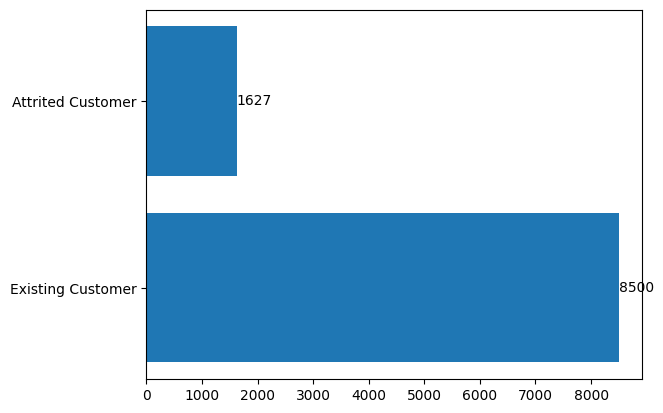

In [298]:
# Plotting (after collecting data back to the local Python environment)
fig, ax = plt.subplots()
bars = ax.barh(x, y)
ax.bar_label(bars)

# Show the plot
plt.show()

## EXPLORATORY DATA ANALYSIS

<font color='Yellow' size='5'> <b> ENCODE CATEGORICAL VARIABLES

### Attrition_Flag:

1 - Existing Customer

0 - Attrited Customer

The  <font color='yellow'> select('Attrition_Flag') </font> method is used to extract only the  <font color='yellow'> 'Attrition_Flag' </font> column from the DataFrame. The  <font color='yellow'> distinct() </font> method is then applied to retain only the unique values in that column. Finally, the  <font color='yellow'>collect()  </font> method is used to gather the unique values into a list of Row objects. <br> <br>The code creates a new list, unique_values, using a list comprehension. It iterates through each Row in the list obtained from the previous step  <font color='yellow'>(unique_values) </font>, extracts the value in the  <font color='yellow'> 'Attrition_Flag' </font> column using  <font color='yellow'> row['Attrition_Flag'] </font>, and collects these values into a new list.

Finally, the code prints the list of unique values.

In [299]:
# Get unique values in the 'Attrition_Flag' column
unique_values = df.select('Attrition_Flag').distinct().collect()

# Extract and print the unique values
unique_values = [row['Attrition_Flag'] for row in unique_values]
print(unique_values)

['Existing Customer', 'Attrited Customer']


<font color='yellow'>StringIndexer </font>is a feature <font color='yellow'> transformer </font> in PySpark that encodes a string column of labels into a column of label indices. In this case, it encodes the <font color='yellow'> 'Attrition_Flag' </font> column into a new column named <font color='yellow'>'Attrition_Flag_index'</font> . The result is added as a new column to the DataFrame.

 <br>
After using the StringIndexer, the resulting '<font color='yellow'>Attrition_Flag_index' </font> column is of type Double. This line of code casts it to IntegerType to ensure it is of the correct numeric data type.  <br>

This line of code retrieves the distinct values in the <font color='yellow'> 'Attrition_Flag_index' </font>column. <br>

The code extracts the unique values from the <font color='yellow'> 'Attrition_Flag_index' </font> column and prints them. The result is a list of unique indices corresponding to the distinct values in the original 'Attrition_Flag' column.

<font color='Yellow'> Encode Categorical variables (String Indexer/label encoding/onehot encoding) </font> Attrition_Flag_index

In [300]:

# Encode 'Attrition_Flag' column
indexer = StringIndexer(inputCol='Attrition_Flag', outputCol='Attrition_Flag_index')
df = indexer.fit(df).transform(df)

# Cast 'Attrition_Flag_index' to IntegerType
df = df.withColumn('Attrition_Flag_index', col('Attrition_Flag_index').cast(IntegerType()))

# Get unique values in the encoded column
unique_values = df.select('Attrition_Flag_index').distinct().collect()

# Extract and print the unique values
unique_values = [row['Attrition_Flag_index'] for row in unique_values]
print(unique_values)

#

[1, 0]


In [301]:
df.show(5)

+-----------------+---+------+----------+-------------+--------------+---------------+-------------+------+---------+---------------+--------------+------------+-----------------+--------------+----------------+------------+-----------+---------------+---------+--------------------+
|   Attrition_Flag|Age|Gender|Dependents|    Education|Marital_Status|Income_Category|Card_Category|Months|Relations|Inactive_Months|Contacts_Count|Credit_Limit|Revolving_balance|Open_Buy_Ratio|Q4_Q1_Amt_Change|Trans_Amount|Trans_Count|Q4_Q1_Ct_Change|Uti_Ratio|Attrition_Flag_index|
+-----------------+---+------+----------+-------------+--------------+---------------+-------------+------+---------+---------------+--------------+------------+-----------------+--------------+----------------+------------+-----------+---------------+---------+--------------------+
|Existing Customer| 54|     M|         2|      Unknown|       Married|   $80K - $120K|         Blue|    42|        4|              2|             3|

### Gender

1 - M

0 - F

This code encodes the categorical values in the column as numerical values, where 'Female' is encoded as 0 and 'Male' is encoded as 1.

In [302]:
# Get unique values in the 'Gender' column and collect the result
unique_values = [row['Gender'] for row in df.select('Gender').distinct().collect()][::-1]

# Print the unique values with the output on the right side
print(unique_values)

['M', 'F']


<font color='Blue'> Encode Categorical variables (String Indexer/label encoding/onehot encoding) </font> Gender_Index

In [303]:
encoder = StringIndexer(inputCol='Gender', outputCol='Gender_Index')
df = encoder.fit(df).transform(df)

# Cast 'Gender_Index' to IntegerType
df = df.withColumn('Gender_Index', df['Gender_Index'].cast(IntegerType()))

# Get unique values in the encoded 'Gender' column
unique_values = df.select('Gender_Index').distinct().collect()

# Extract and print the unique values
unique_values = [row['Gender_Index'] for row in unique_values][::-1]
print(unique_values)

[0, 1]


In [304]:
df.show(5)

+-----------------+---+------+----------+-------------+--------------+---------------+-------------+------+---------+---------------+--------------+------------+-----------------+--------------+----------------+------------+-----------+---------------+---------+--------------------+------------+
|   Attrition_Flag|Age|Gender|Dependents|    Education|Marital_Status|Income_Category|Card_Category|Months|Relations|Inactive_Months|Contacts_Count|Credit_Limit|Revolving_balance|Open_Buy_Ratio|Q4_Q1_Amt_Change|Trans_Amount|Trans_Count|Q4_Q1_Ct_Change|Uti_Ratio|Attrition_Flag_index|Gender_Index|
+-----------------+---+------+----------+-------------+--------------+---------------+-------------+------+---------+---------------+--------------+------------+-----------------+--------------+----------------+------------+-----------+---------------+---------+--------------------+------------+
|Existing Customer| 54|     M|         2|      Unknown|       Married|   $80K - $120K|         Blue|    42|  

### Education

Shows unique values present in the 'Education' column of the df dataframe.

In [305]:
# Get unique values in the 'Education' column
unique_values = df.select('Education').distinct().collect()

# Extract and print the unique values
unique_values = [row['Education'] for row in unique_values]
print(unique_values)

['High School', 'Unknown', 'Uneducated', 'Post-Graduate', 'Doctorate', 'Graduate', 'College']


This code creates a subplot in a 1x2 grid, with the first subplot showing the distribution of the Education column in the df DataFrame. <br>
The second subplot showing the distribution of the Education column in the churn_df DataFrame (which only contains the rows with "Attrited Customer" in the Attrition_Flag column).

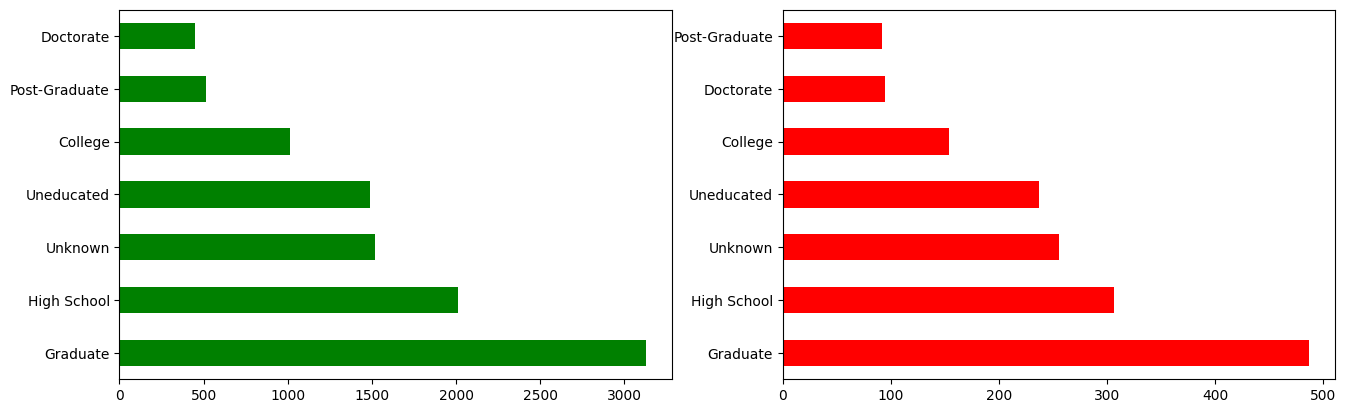

In [306]:
# Collecting data to the local Python environment
df_pd = df.toPandas()
churn_df_pd = churn_df.toPandas()

# Plotting using Matplotlib
plt.subplot(1, 2, 1)
df_pd['Education'].value_counts().plot(kind='barh', color='green')
plt.title('Education - All Customers')
plt.subplot(1, 2, 2)
churn_df_pd['Education'].value_counts().plot(kind='barh', color='red')
plt.title('Education - Attrited Customers')
plt.subplots_adjust(left=0.5, right=2.4)

# Show the plot
plt.show()

This code encodes the categorical values in the column as numerical values, where 'Highschool' is encoded as 3,'Graduate' is encoded as 2 and so on. <br><br>
<font color='Yellow'> Encode Categorical variables (String Indexer/label encoding/onehot encoding) </font> Encoded_Education

In [307]:
encoder = StringIndexer(inputCol='Education', outputCol='Encoded_Education')
df = encoder.fit(df).transform(df)

# Cast 'Encoded_Education' to IntegerType
df = df.withColumn('Encoded_Education', col('Encoded_Education').cast(IntegerType()))

# Get unique values in the encoded column
unique_values = df.select('Encoded_Education').distinct().collect()

# Extract and print the unique values
unique_values = [row['Encoded_Education'] for row in unique_values]
print(unique_values)

[1, 6, 3, 5, 4, 2, 0]


3 - High School <br>
2 - Graduate<br>
5 - Uneducated<br>
6 - Unknown<br>
0 - College<br>
4 - Post Graduate<br>
1 - Doctorate<br>

In [308]:
df.show(5)

+-----------------+---+------+----------+-------------+--------------+---------------+-------------+------+---------+---------------+--------------+------------+-----------------+--------------+----------------+------------+-----------+---------------+---------+--------------------+------------+-----------------+
|   Attrition_Flag|Age|Gender|Dependents|    Education|Marital_Status|Income_Category|Card_Category|Months|Relations|Inactive_Months|Contacts_Count|Credit_Limit|Revolving_balance|Open_Buy_Ratio|Q4_Q1_Amt_Change|Trans_Amount|Trans_Count|Q4_Q1_Ct_Change|Uti_Ratio|Attrition_Flag_index|Gender_Index|Encoded_Education|
+-----------------+---+------+----------+-------------+--------------+---------------+-------------+------+---------+---------------+--------------+------------+-----------------+--------------+----------------+------------+-----------+---------------+---------+--------------------+------------+-----------------+
|Existing Customer| 54|     M|         2|      Unknown|

### Subplots Age

This will produce two histograms side-by-side. The first histogram will show the distribution of 'Age' in the entire dataframe and the second histogram will show the distribution of 'Age' in the "churned customer" dataframe.

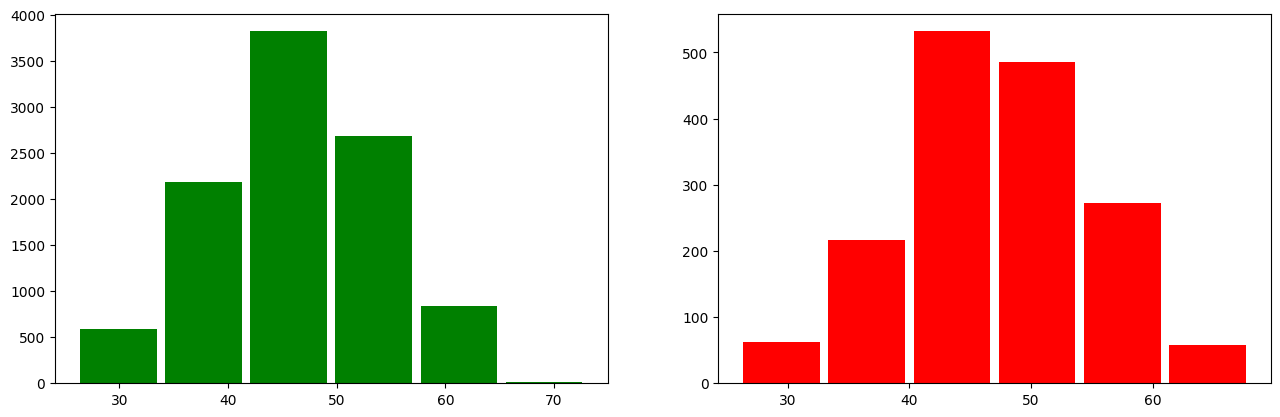

In [309]:
df_age_values = df.select('Age').rdd.flatMap(lambda x: x).collect()
churn_df_age_values = churn_df.select('Age').rdd.flatMap(lambda x: x).collect()

# Plotting using Matplotlib
plt.subplot(1, 2, 1)
plt.hist(df_age_values, rwidth=0.9, color='g', bins=6)

plt.subplot(1, 2, 2)
plt.hist(churn_df_age_values, rwidth=0.9, color='r', bins=6)

plt.subplots_adjust(left=0.5, right=2.4)

# Show the plot
plt.show()

In [310]:
df.show(5)

+-----------------+---+------+----------+-------------+--------------+---------------+-------------+------+---------+---------------+--------------+------------+-----------------+--------------+----------------+------------+-----------+---------------+---------+--------------------+------------+-----------------+
|   Attrition_Flag|Age|Gender|Dependents|    Education|Marital_Status|Income_Category|Card_Category|Months|Relations|Inactive_Months|Contacts_Count|Credit_Limit|Revolving_balance|Open_Buy_Ratio|Q4_Q1_Amt_Change|Trans_Amount|Trans_Count|Q4_Q1_Ct_Change|Uti_Ratio|Attrition_Flag_index|Gender_Index|Encoded_Education|
+-----------------+---+------+----------+-------------+--------------+---------------+-------------+------+---------+---------------+--------------+------------+-----------------+--------------+----------------+------------+-----------+---------------+---------+--------------------+------------+-----------------+
|Existing Customer| 54|     M|         2|      Unknown|

## Marital status

Shows unique values present in the 'Marital_Status' column of the df dataframe.

In [311]:
# Get unique values in the 'Marital_Status' column
unique_values = df.select('Marital_Status').distinct().collect()

# Extract and print the unique values
unique_values = [row['Marital_Status'] for row in unique_values]
print(unique_values)

['Unknown', 'Married', 'Divorced', 'Single']


This code is creating a bar plot to visualize the distribution of the Marital_Status column of the dataframe.

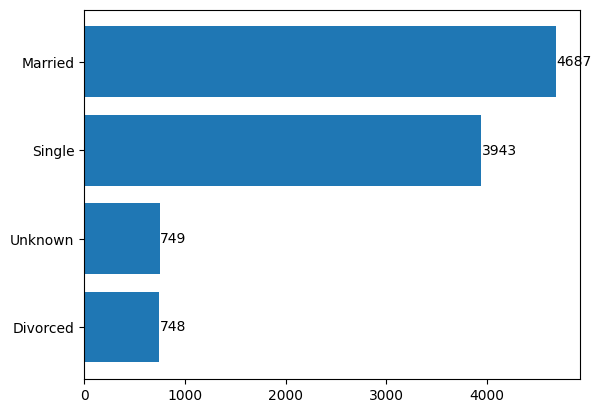

In [312]:
# Group by 'Marital_Status' and count occurrences
marital_status_counts = df.groupBy('Marital_Status').count().orderBy('count', ascending=True).collect()

# Extract data for plotting
y = [row['count'] for row in marital_status_counts]
x = [row['Marital_Status'] for row in marital_status_counts]


# Plotting using Matplotlib
fig, ax = plt.subplots()
bars = ax.barh(x, y)
ax.bar_label(bars)

# Show the plot
plt.show()

This code encodes the categorical values in the column as numerical values, where 'Married' is encoded as 1,'Single' is encoded as 2 and so on.<br>

1 - Married<br>
2 - Single<br>
3 - Unknown<br>
0 - Divorced<br>


<font color='Yellow'> Encode Categorical variables (String Indexer/label encoding/onehot encoding) </font> Marital_Status_Index

In [313]:
# Create a StringIndexer to encode 'Marital_Status'
encoder = StringIndexer(inputCol='Marital_Status', outputCol='Marital_Status_Index')
df = encoder.fit(df).transform(df)

# Cast 'Marital_Status_Index' to IntegerType
df = df.withColumn('Marital_Status_Index', col('Marital_Status_Index').cast(IntegerType()))

# Get unique values in the encoded 'Marital_Status' column
unique_values = df.select('Marital_Status_Index').distinct().collect()

# Extract and print the unique values
unique_values = [row['Marital_Status_Index'] for row in unique_values]
print(unique_values)

[1, 3, 2, 0]


### Income Category 

Shows unique values present in the 'Marital_Status' column of the df dataframe.

In [314]:
# Get unique values in the 'Income_Category' column
unique_values = df.select('Income_Category').distinct().collect()

# Extract and print the unique values
unique_values = [row['Income_Category'] for row in unique_values]
print(unique_values)

['$120K +', '$60K - $80K', '$80K - $120K', 'Unknown', '$40K - $60K', 'Less than $40K']


This code plots two horizontal bar graphs side by side to compare the distribution of the values of the column "Income_Category" in the original dataframe (df) and the dataframe of customers who churned (churn_df).  <br>
The first graph (subplot 1) shows the frequency of each value in the column "Income_Category" for the entire dataframe (df) and is represented in green color. <br>
The second graph (subplot 2) shows the frequency of each value in the column "Income_Category" for the churned customers dataframe (churn_df) and is represented in red color.

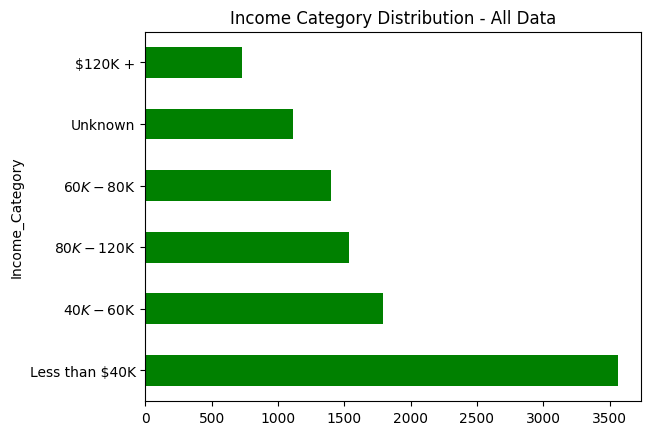

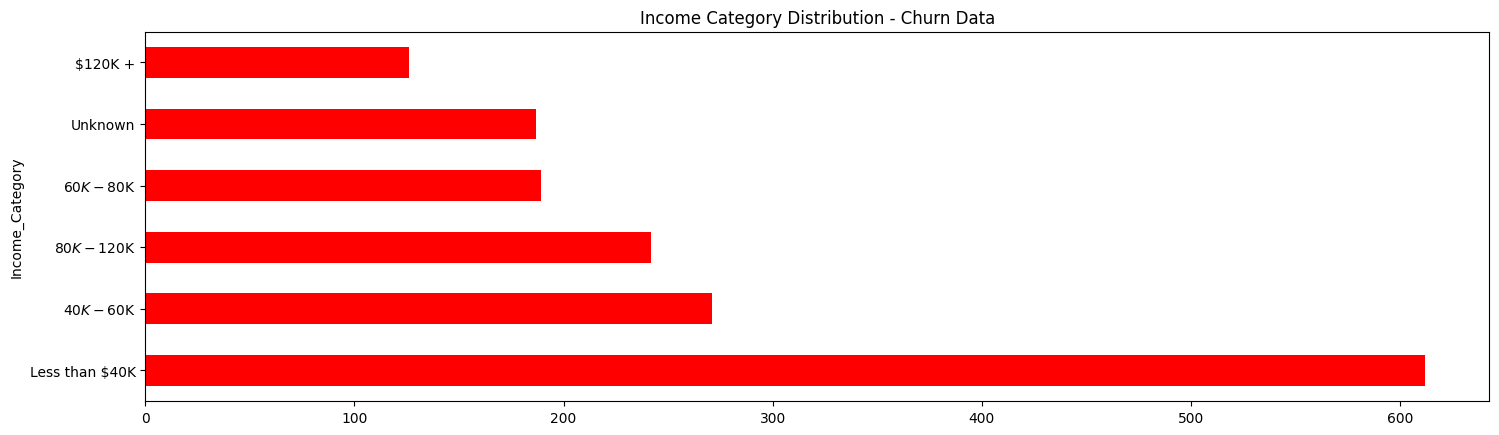

In [315]:
# Income_Category' is the column to be plotted
# plt.subplot(1, 2, 1)
df.groupBy('Income_Category').count().orderBy('count', ascending=False).toPandas().plot(kind='barh', x='Income_Category', y='count', color='green', legend=False)
plt.title('Income Category Distribution - All Data')

# plt.subplot(1, 2, 2)
churn_df.groupBy('Income_Category').count().orderBy('count', ascending=False).toPandas().plot(kind='barh', x='Income_Category', y='count', color='red', legend=False)
plt.title('Income Category Distribution - Churn Data')

plt.subplots_adjust(left=0.2, right=2.3)
plt.show()

This code encodes the categorical values in the column as numerical values, where '60k - 80k' is encoded as 2,'40k - 60k' is encoded as 4 and so on.

2 : 60k - 80k <br>
4 : 40k - 60k<br>
3 : 80k - 120k<br>
1 : Unknown<br>
0 : $120k+<br>
5: Less than $40k<br>

<font color='Yellow'> Encode Categorical variables (String Indexer/label encoding/onehot encoding) </font> Income_Category_Index

In [316]:
# Income_Category' is the column to be label encoded
encoder = StringIndexer(inputCol='Income_Category', outputCol='Income_Category_Index')
df = encoder.fit(df).transform(df)

# Cast 'Income_Category_Index' to IntegerType
df = df.withColumn('Income_Category_Index', col('Income_Category_Index').cast(IntegerType()))

# Get unique values in the encoded 'Income_Category' column
unique_values = df.select('Income_Category_Index').distinct().collect()

# Extract and print the unique values
unique_values = [row['Income_Category_Index'] for row in unique_values]
print(unique_values)

[1, 3, 5, 4, 2, 0]


## Card Category 

In [317]:
# Get unique values in the 'Card_Category' column
unique_values = df.select('Card_Category').distinct().collect()

# Extract and print the unique values
unique_values = [row['Card_Category'] for row in unique_values]
print(unique_values)

['Platinum', 'Silver', 'Blue', 'Gold']


This code is creating a bar plot to visualize the distribution of the 'Card_Category' column of the dataframe.

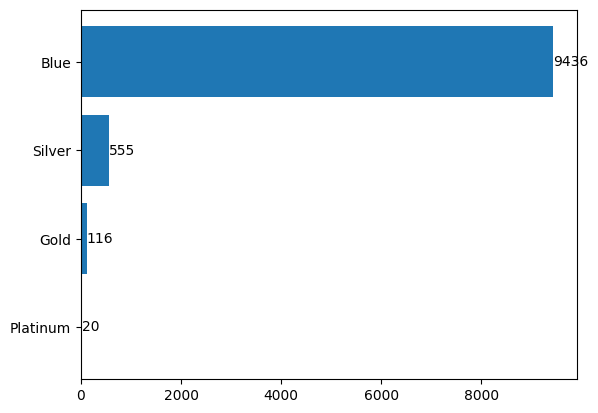

In [318]:
# Assuming 'Card_Category' is the column to be plotted
card_category_counts = df.groupBy('Card_Category').count().orderBy('count', ascending=True).toPandas()

# Extract data for plotting
x = card_category_counts['Card_Category'].tolist()
y = card_category_counts['count'].tolist()

# Plotting using Matplotlib
fig, ax = plt.subplots()
bars = ax.barh(x, y)
ax.bar_label(bars)

# Show the plot
plt.show()

This code encodes the categorical values in the column as numerical values, where 'Platinum' is encoded as 0,'Gold' is encoded as 1 and so on. <br>
0 : Platinum <br>
1 : Gold<br>
2 : Silver<br>
3 : Blue<br>

<font color='Yellow'> Encode Categorical variables (String Indexer/label encoding/onehot encoding) </font> Card_Category_Index

In [319]:
encoder = StringIndexer(inputCol='Card_Category', outputCol='Card_Category_Index')
df = encoder.fit(df).transform(df)

# Cast 'Card_Category_Index' to IntegerType
df = df.withColumn('Card_Category_Index', col('Card_Category_Index').cast(IntegerType()))

# Get unique values in the encoded 'Card_Category' column
unique_values = df.select('Card_Category_Index').distinct().collect()

# Extract and print the unique values
unique_values = [row['Card_Category_Index'] for row in unique_values]
print(unique_values)

[1, 3, 2, 0]


In [320]:
df.show()

+-----------------+---+------+----------+-------------+--------------+---------------+-------------+------+---------+---------------+--------------+------------+-----------------+--------------+----------------+------------+-----------+---------------+---------+--------------------+------------+-----------------+--------------------+---------------------+-------------------+
|   Attrition_Flag|Age|Gender|Dependents|    Education|Marital_Status|Income_Category|Card_Category|Months|Relations|Inactive_Months|Contacts_Count|Credit_Limit|Revolving_balance|Open_Buy_Ratio|Q4_Q1_Amt_Change|Trans_Amount|Trans_Count|Q4_Q1_Ct_Change|Uti_Ratio|Attrition_Flag_index|Gender_Index|Encoded_Education|Marital_Status_Index|Income_Category_Index|Card_Category_Index|
+-----------------+---+------+----------+-------------+--------------+---------------+-------------+------+---------+---------------+--------------+------------+-----------------+--------------+----------------+------------+-----------+--------

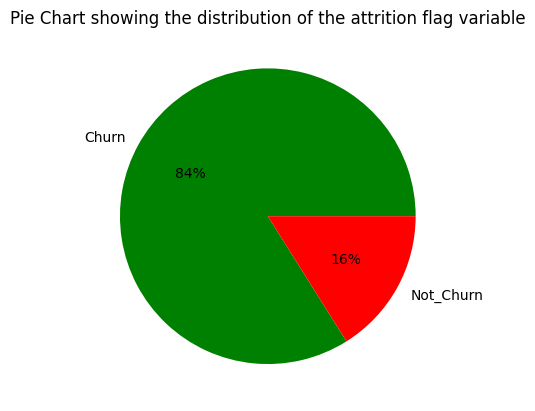

In [321]:
# Attrition_Flag' is the column to be plotted
attrition_flag_counts = df.groupBy('Attrition_Flag').count().toPandas()

# Plotting using Matplotlib
plt.pie(attrition_flag_counts['count'], labels=['Churn', 'Not_Churn'], autopct='%.0f%%', colors='gr')
plt.title("Pie Chart showing the distribution of the attrition flag variable")

# Show the plot
plt.show()

We can see from the above pie chart that the target variable is imbalanced.

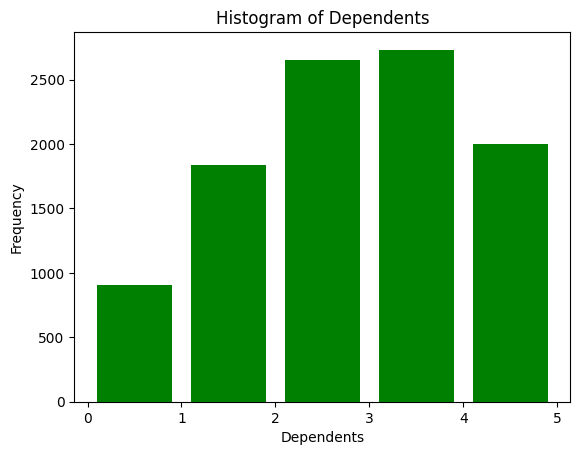

In [322]:
# Dependents' is the column to be plotted
dependents_histogram = df.select('Dependents').rdd.flatMap(lambda x: x).histogram(5)

# Extracting bins and counts
bins = dependents_histogram[0]
counts = dependents_histogram[1]

# Plotting using Matplotlib
plt.hist(bins[:-1], bins, weights=counts, rwidth=0.8, color='g')
plt.xlabel('Dependents')
plt.ylabel('Frequency')
plt.title('Histogram of Dependents')

# Show the plot
plt.show()

This code creates a histogram of the "Dependents" column in the "df" dataframe. The histogram has 5 bins and the bar width is set to 0.8, with the color of the bars being green.

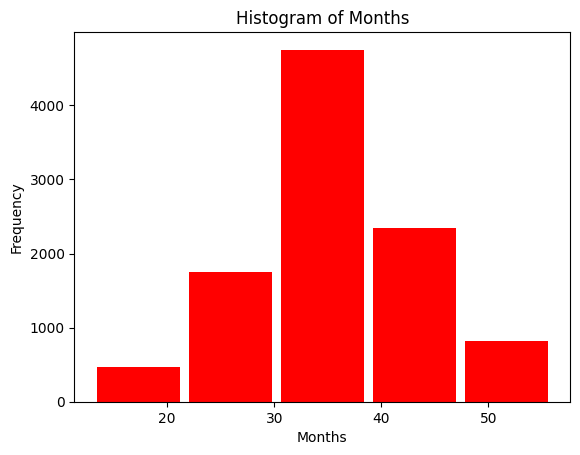

In [323]:
# 'Months' is the column to be plotted
months_histogram = df.select('Months').rdd.flatMap(lambda x: x).histogram(5)

# Extracting bins and counts
bins = months_histogram[0]
counts = months_histogram[1]

# Plotting using Matplotlib
plt.hist(bins[:-1], bins, weights=counts, color='r', rwidth=0.9)
plt.xlabel('Months')
plt.ylabel('Frequency')
plt.title('Histogram of Months')

# Show the plot
plt.show()

This code creates a histogram of the "Months" column in the "df" dataframe. The histogram has 5 bins and the bar width is set to 0.9, with the color of the bars being red.

In [324]:

# 'Gender' is the column to be counted
gender_counts = df.groupBy('Gender').count()

# Show the counts
gender_counts.show()

+------+-----+
|Gender|count|
+------+-----+
|     F| 5358|
|     M| 4769|
+------+-----+



There are 5358 female customers and 4769 male customers.

## Piecharts - For comparative analysis between 2 classes 

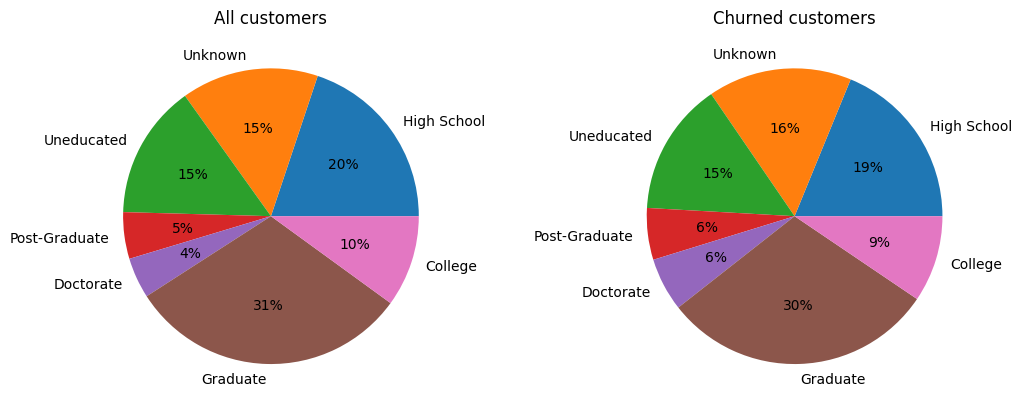

In [325]:
# 'Education' is the column to be plotted
education_counts_all = df.groupBy('Education').count().toPandas()
education_counts_churn = churn_df.groupBy('Education').count().toPandas()

# Plotting using Matplotlib
plt.subplot(1, 2, 1)
plt.pie(education_counts_all['count'], labels=education_counts_all['Education'], autopct='%.0f%%')
plt.title("All customers")

plt.subplot(1, 2, 2)
plt.pie(education_counts_churn['count'], labels=education_counts_churn['Education'], autopct='%.0f%%')
plt.title("Churned customers")

plt.subplots_adjust(left=0.5, right=2)
plt.show()

The second chart shows how the education levels of customers who have left are spread out so that you can count how many times each level of education is shown. This pie chart also shows the levels of education, and the autopct argument shows the percentage of the whole. The distribution in the second chart is the same as in the first, but the distribution of the two lowest degrees, doctorate and postgraduate, is different.

The first chart shows how the genders of all customers are spread out so that you can count how many of each gender there are. 
The pie chart is labeled with "Female" and "Male" to show the different genders, and the autopct argument shows the percentage of the whole. With the 'colors' argument, green and red are chosen as the chart's colors. 


The second chart shows how the genders of customers who have left are spread out so that you can count how many of each gender there are. The gender levels are labeled "Female" and "Male" on this pie chart, and the autopct argument is used to show the percentage of the total.



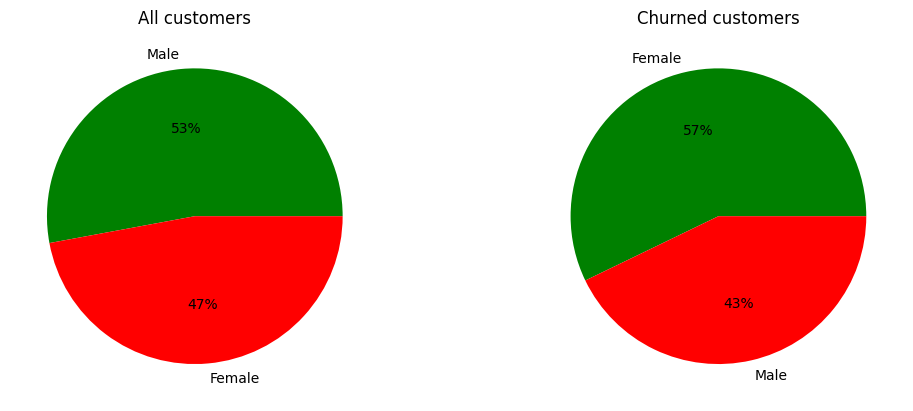

In [326]:
# 'Gender' is the column to be plotted
gender_counts_all = df.groupBy('Gender').count().toPandas()
gender_counts_churn = churn_df.groupBy('Gender').count().toPandas()

# Plotting using Matplotlib
plt.subplot(1, 2, 1)
plt.pie(gender_counts_all['count'], labels=['Male', 'Female'], autopct='%.0f%%', colors=['g', 'r'])
plt.title("All customers")

plt.subplot(1, 2, 2)
plt.pie(gender_counts_churn['count'], labels=['Female', 'Male'], autopct='%.0f%%', colors=['g', 'r'])
plt.title("Churned customers")

plt.subplots_adjust(left=0.5, right=2)
plt.show()

The first chart shows how the customers' education levels are spread out so that you can count how many times each level shows up. The education levels are labeled on the pie chart, and the autopct argument shows the percentage of the whole. For the first chart, the most graduates are shown, followed by high school graduates, then unknown and uneducated people.

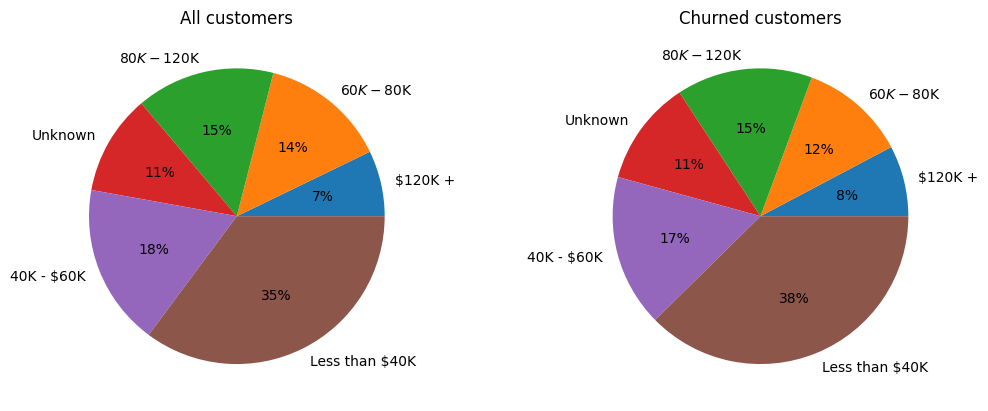

In [327]:
# Income_Category' is the column to be plotted
income_category_counts_all = df.groupBy('Income_Category').count().toPandas()
income_category_counts_churn = churn_df.groupBy('Income_Category').count().toPandas()

# Plotting using Matplotlib
plt.subplot(1, 2, 1)
plt.pie(income_category_counts_all['count'], labels=['$120K +', '$60K - $80K', '$80K - $120K', 'Unknown', '40K - $60K', 'Less than $40K'], autopct='%.0f%%')
plt.title("All customers")

plt.subplot(1, 2, 2)
plt.pie(income_category_counts_churn['count'], labels=['$120K +', '$60K - $80K', '$80K - $120K', 'Unknown', '40K - $60K', 'Less than $40K'], autopct='%.0f%%')
plt.title("Churned customers")

plt.subplots_adjust(left=0.5, right=2)
plt.show()

To keep track of how many times each income category shows up for each customer, the first chart shows how those income categories are spread out. The pie chart shows the different types of income, and the autopct argument shows the percentage of the whole. For the first chart, customers making less than $40,000 make up the biggest chunk. These are followed by customers making between $40,000 and $100,000 and then $80,000 to $120,000. Customers making $120,000 or more have the lowest distribution rate, at 7%.

The second chart shows how the different types of income are spread out among customers who have left, so you can count how many times each type of income appears. The churned data set also has a similar pattern of distribution.

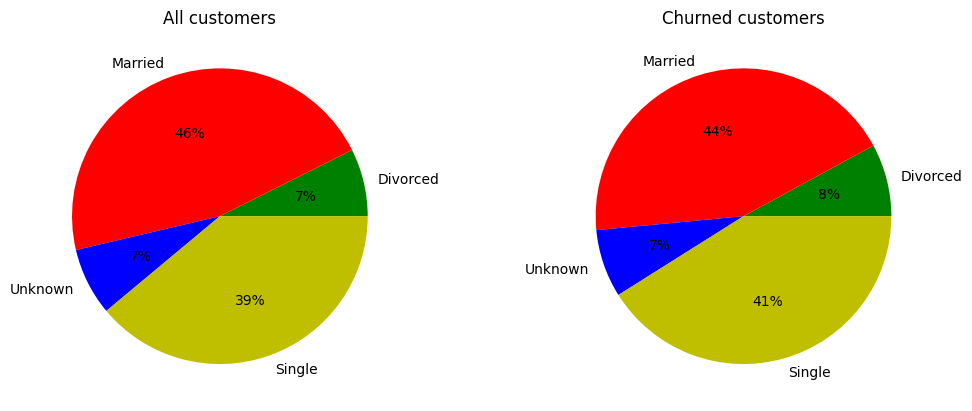

In [328]:
# Marital_Status' is the column to be plotted
marital_status_counts_all = df.groupBy('Marital_Status').count().toPandas()
marital_status_counts_churn = churn_df.groupBy('Marital_Status').count().toPandas()

# Plotting using Matplotlib
plt.subplot(1, 2, 1)
plt.pie(marital_status_counts_all['count'], labels=['Divorced', 'Married', 'Unknown', 'Single'], autopct='%.0f%%', colors=['g', 'r', 'b', 'y'])
plt.title("All customers")

plt.subplot(1, 2, 2)
plt.pie(marital_status_counts_churn['count'], labels=['Divorced', 'Married', 'Unknown', 'Single'], autopct='%.0f%%', colors=['g', 'r', 'b', 'y'])
plt.title("Churned customers")

plt.subplots_adjust(left=0.5, right=2)
plt.show()

The first chart shows how the different income levels are spread out among all customers so that we can keep track of how many people are married in each situation. The marital statuses are labeled on the pie chart, and the autopct argument shows the percentage of the total. Green, red, blue, and orange make up the color scheme.

The second chart shows how the different marital statuses of customers who have left are spread out so that you can count how many times each status is seen.

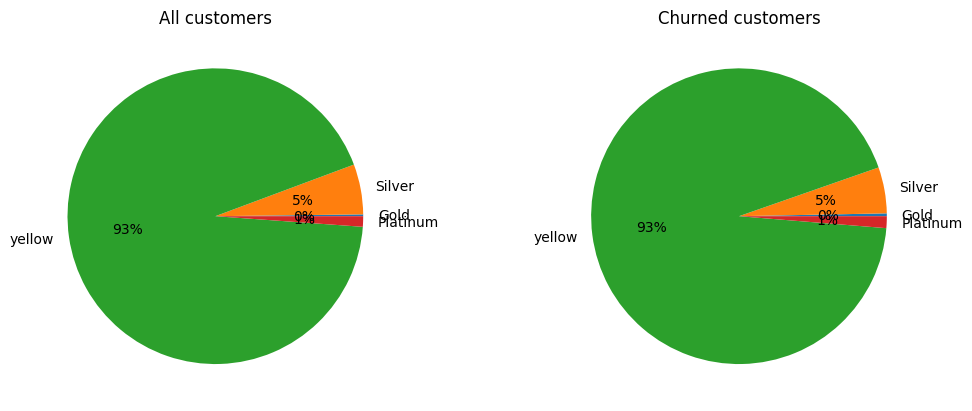

In [329]:
# Assuming 'Card_Category' is the column to be plotted
card_category_counts_all = df.groupBy('Card_Category').count().toPandas()
card_category_counts_churn = churn_df.groupBy('Card_Category').count().toPandas()

# Plotting using Matplotlib
plt.subplot(1, 2, 1)
plt.pie(card_category_counts_all['count'], labels=['Gold', 'Silver', 'yellow', 'Platinum'], autopct='%.0f%%')
plt.title("All customers")

plt.subplot(1, 2, 2)
plt.pie(card_category_counts_churn['count'], labels=['Gold', 'Silver', 'yellow', 'Platinum'], autopct='%.0f%%')
plt.title("Churned customers")

plt.subplots_adjust(left=0.5, right=2)
plt.show()

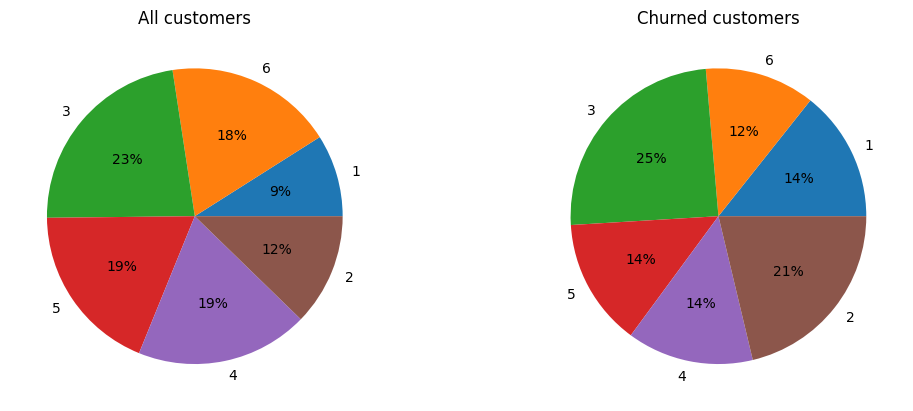

In [330]:
# Assuming 'Relations' is the column to be plotted
relations_counts_all = df.groupBy('Relations').count().toPandas()
relations_counts_churn = churn_df.groupBy('Relations').count().toPandas()

# Plotting using Matplotlib
plt.subplot(1, 2, 1)
plt.pie(relations_counts_all['count'], labels=['1', '6', '3', '5', '4', '2'], autopct='%.0f%%')
plt.title("All customers")

plt.subplot(1, 2, 2)
plt.pie(relations_counts_churn['count'], labels=['1', '6', '3', '5', '4', '2'], autopct='%.0f%%')
plt.title("Churned customers")

plt.subplots_adjust(left=0.5, right=2)
plt.show()

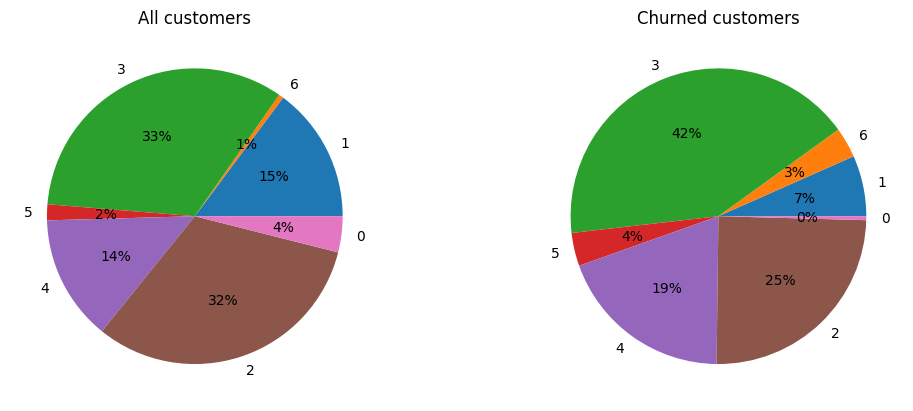

In [331]:
contacts_counts_all = df.groupBy('Contacts_Count').count().toPandas()
contacts_counts_churn = churn_df.groupBy('Contacts_Count').count().toPandas()

# Plotting using Matplotlib
plt.subplot(1, 2, 1)
plt.pie(contacts_counts_all['count'], labels=['1', '6', '3', '5', '4', '2', '0'], autopct='%.0f%%')
plt.title("All customers")

plt.subplot(1, 2, 2)
plt.pie(contacts_counts_churn['count'], labels=['1', '6', '3', '5', '4', '2', '0'], autopct='%.0f%%')
plt.title("Churned customers")

plt.subplots_adjust(left=0.5, right=2)
plt.show()

In [332]:
df.head()

Row(Attrition_Flag='Existing Customer', Age=54, Gender='M', Dependents=2, Education='Unknown', Marital_Status='Married', Income_Category='$80K - $120K', Card_Category='Blue', Months=42, Relations=4, Inactive_Months=2, Contacts_Count=3, Credit_Limit=12217.0, Revolving_balance=0, Open_Buy_Ratio=12217.0, Q4_Q1_Amt_Change=1.075, Trans_Amount=1110, Trans_Count=21, Q4_Q1_Ct_Change=0.75, Uti_Ratio=0.0, Attrition_Flag_index=0, Gender_Index=1, Encoded_Education=2, Marital_Status_Index=0, Income_Category_Index=2, Card_Category_Index=0)

In [333]:

# List of columns to drop
columns_to_drop = ['Attrition_Flag', 'Gender','Education',
                   'Marital_Status','Income_Category',
                   'Card_Category','Churn_Prob']

# Drop the specified columns
df = df.drop(*columns_to_drop)

In [334]:
# Rename the specified columns
columns_mapping = {
    'Attrition_Flag_index': 'Attrition_Flag',
    'Gender_Index': 'Gender',
    'Encoded_Education': 'Education',
    'Marital_Status_Index': 'Marital_Status',
    'Income_Category_Index': 'Income_Category',
    'Card_Category_Index': 'Card_Category',

}

for old_col, new_col in columns_mapping.items():
    df = df.withColumnRenamed(old_col, new_col)

In [335]:
# Show the updated DataFrame
df.show(5)

+---+----------+------+---------+---------------+--------------+------------+-----------------+--------------+----------------+------------+-----------+---------------+---------+--------------+------+---------+--------------+---------------+-------------+
|Age|Dependents|Months|Relations|Inactive_Months|Contacts_Count|Credit_Limit|Revolving_balance|Open_Buy_Ratio|Q4_Q1_Amt_Change|Trans_Amount|Trans_Count|Q4_Q1_Ct_Change|Uti_Ratio|Attrition_Flag|Gender|Education|Marital_Status|Income_Category|Card_Category|
+---+----------+------+---------+---------------+--------------+------------+-----------------+--------------+----------------+------------+-----------+---------------+---------+--------------+------+---------+--------------+---------------+-------------+
| 54|         2|    42|        4|              2|             3|     12217.0|                0|       12217.0|           1.075|        1110|         21|           0.75|      0.0|             0|     1|        2|             0|       

In [336]:
df.columns

['Age',
 'Dependents',
 'Months',
 'Relations',
 'Inactive_Months',
 'Contacts_Count',
 'Credit_Limit',
 'Revolving_balance',
 'Open_Buy_Ratio',
 'Q4_Q1_Amt_Change',
 'Trans_Amount',
 'Trans_Count',
 'Q4_Q1_Ct_Change',
 'Uti_Ratio',
 'Attrition_Flag',
 'Gender',
 'Education',
 'Marital_Status',
 'Income_Category',
 'Card_Category']

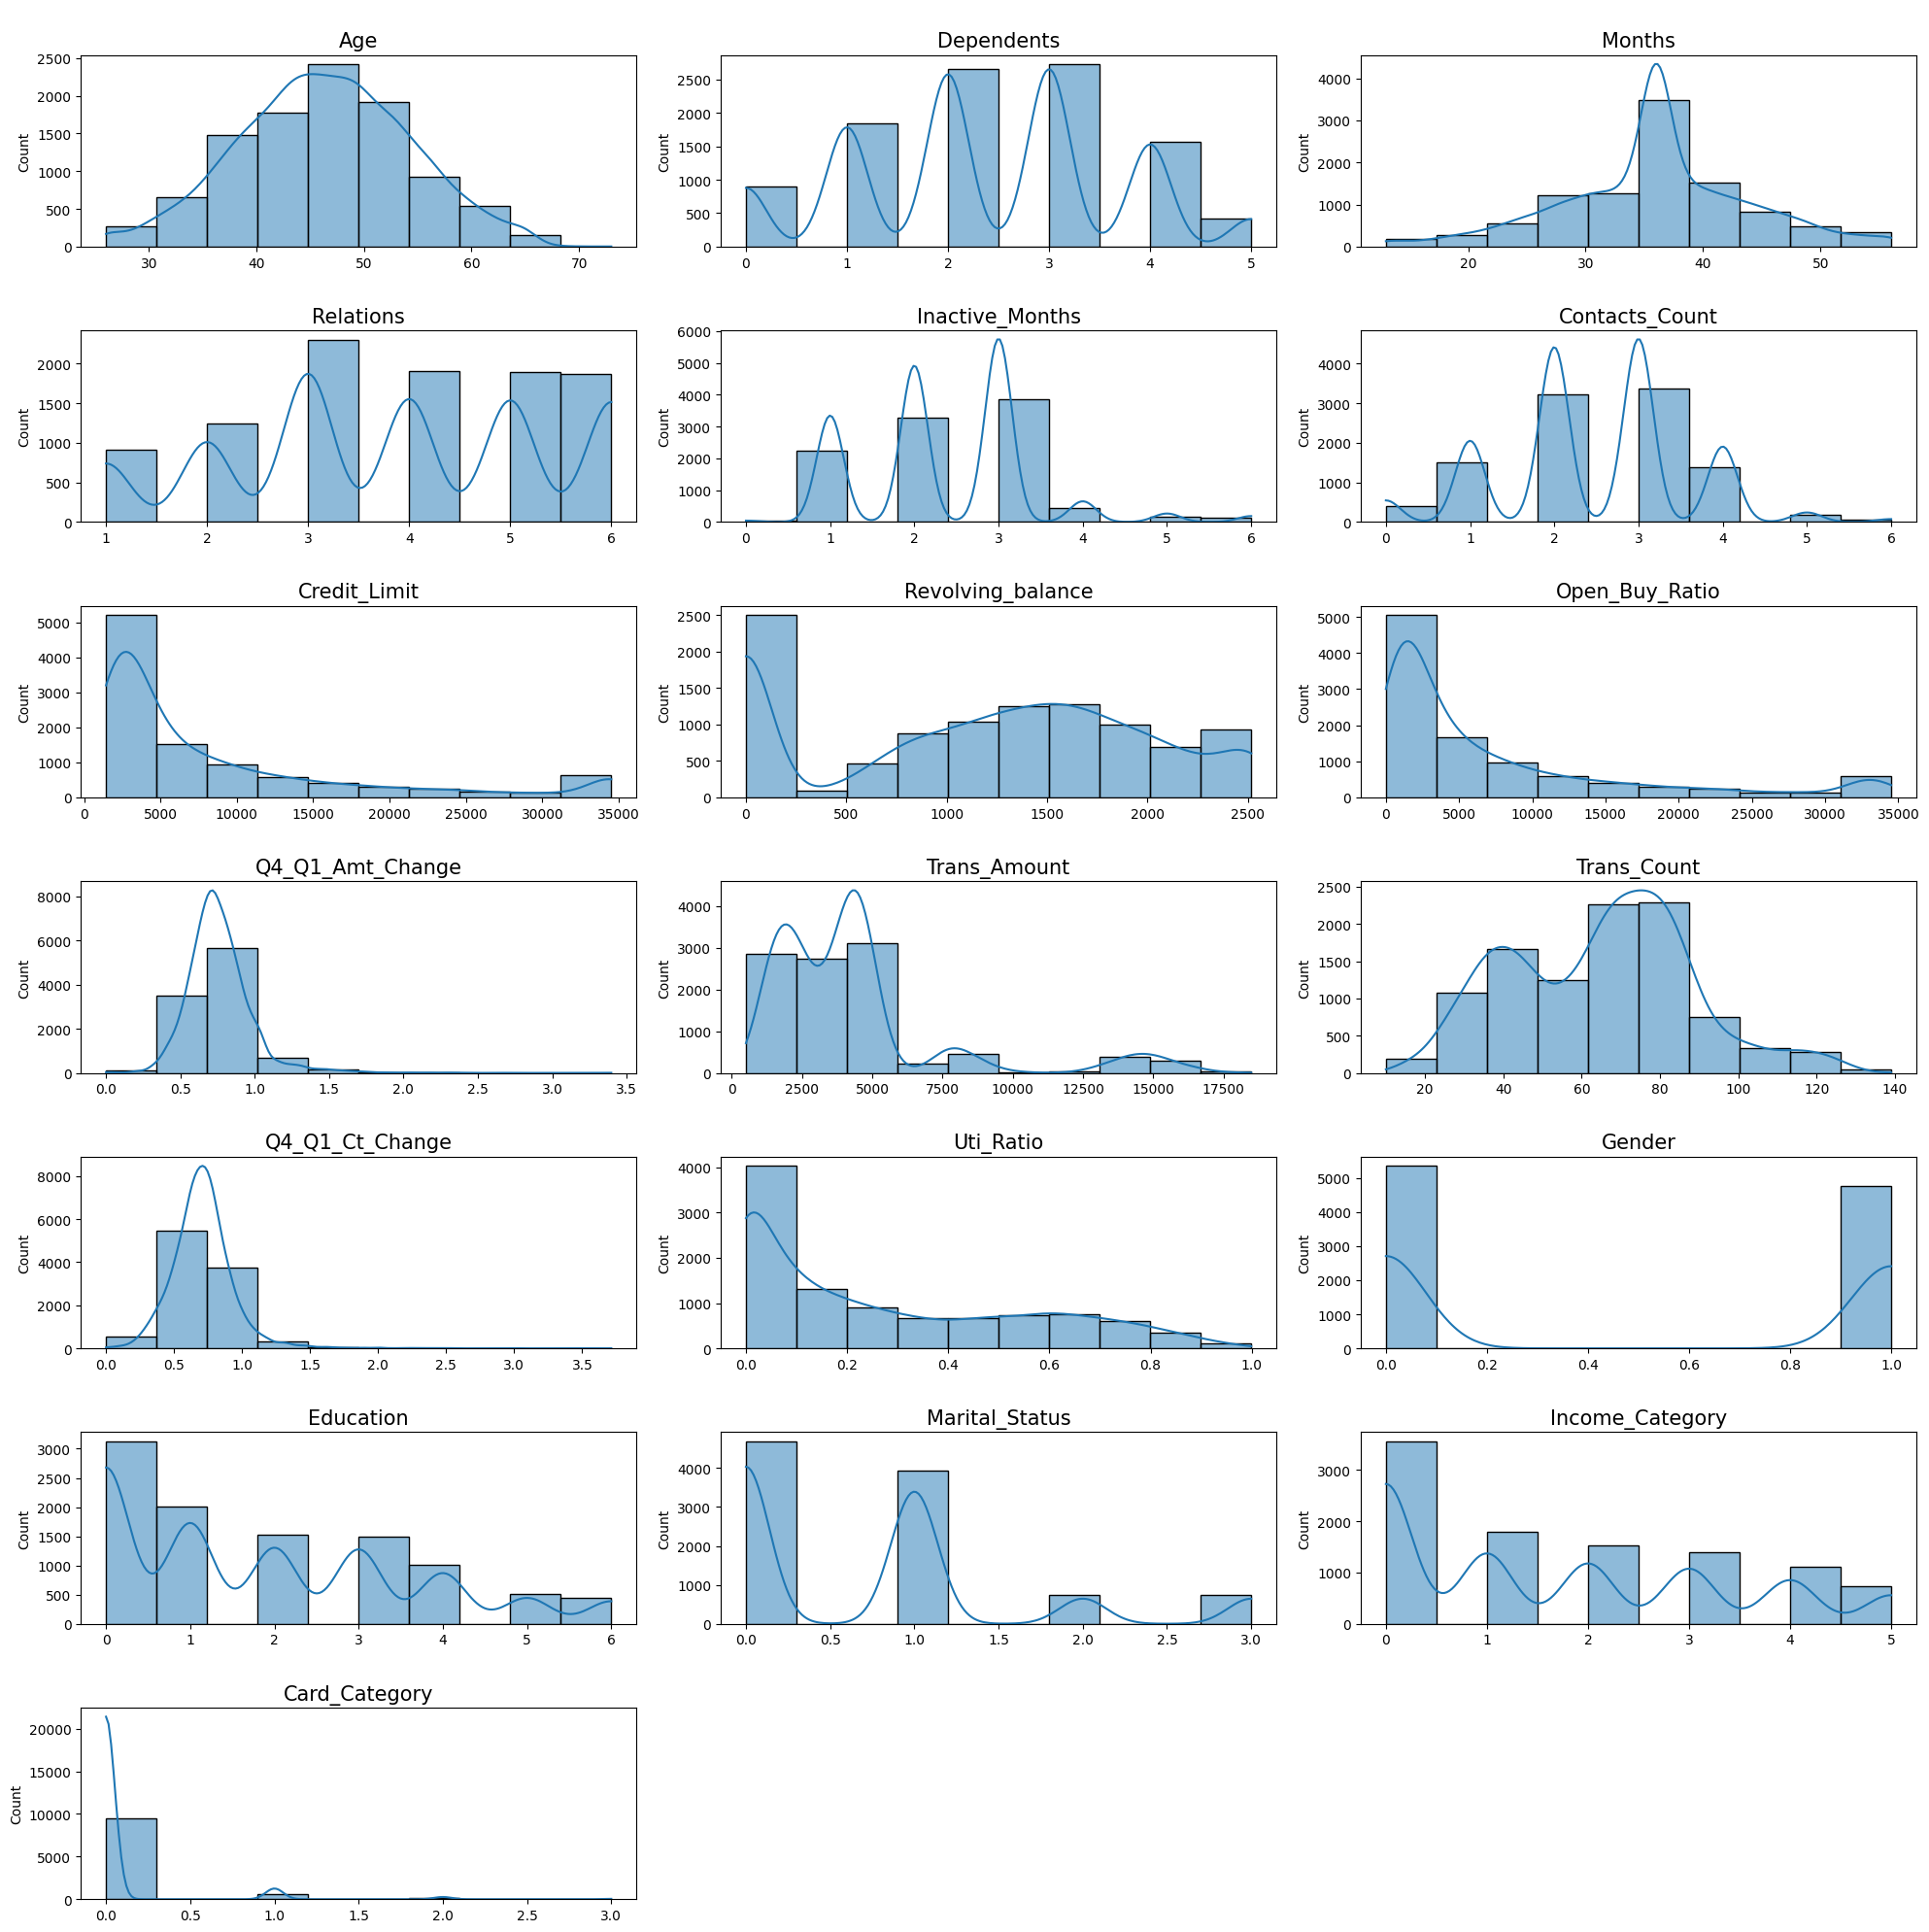

In [337]:
# Extract numerical features
numerical_features = [col_name for col_name, data_type in df.dtypes if data_type != 'string']

# Set up the plot
plt.figure(figsize=(20, 20))
plot_number = 1
bins_num = 10

# Plot histograms for numerical features
for eachCol in numerical_features:
    if eachCol != "Attrition_Flag":
        x = df.select(eachCol).rdd.flatMap(lambda x: x).collect()
        ax = plt.subplot(7, 3, plot_number)
        sns.histplot(x, ax=ax, bins=bins_num, kde=True)
        plt.title(f"\n{eachCol}", fontsize=15)
        plot_number += 1

plt.tight_layout()
plt.show()

In [338]:
from pyspark.ml.feature import Imputer

In [339]:
# Specify the categorical columns you want to treat
categorical_columns = ['Attrition_Flag', 'Gender', 'Education', 'Marital_Status', 'Income_Category', 'Card_Category']

# Handling Missing Values
imputer = Imputer(
    inputCols=categorical_columns,
    outputCols=[f"{col}_imputed" for col in categorical_columns],
    strategy='mode'  # Corrected parameter name for most frequent value
)

df_imputed = imputer.fit(df).transform(df)

# Convert Categorical Columns to Numerical using StringIndexer
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid="keep") for col in categorical_columns]

df_indexed = df_imputed
for indexer in indexers:
    df_indexed = indexer.fit(df_indexed).transform(df_indexed)

# Show the treated DataFrame
df_indexed.show()

+---+----------+------+---------+---------------+--------------+------------+-----------------+--------------+----------------+------------+-----------+---------------+---------+--------------+------+---------+--------------+---------------+-------------+----------------------+--------------+-----------------+----------------------+-----------------------+---------------------+----------------------+--------------+-----------------+----------------------+-----------------------+---------------------+
|Age|Dependents|Months|Relations|Inactive_Months|Contacts_Count|Credit_Limit|Revolving_balance|Open_Buy_Ratio|Q4_Q1_Amt_Change|Trans_Amount|Trans_Count|Q4_Q1_Ct_Change|Uti_Ratio|Attrition_Flag|Gender|Education|Marital_Status|Income_Category|Card_Category|Attrition_Flag_imputed|Gender_imputed|Education_imputed|Marital_Status_imputed|Income_Category_imputed|Card_Category_imputed|Attrition_Flag_indexed|Gender_indexed|Education_indexed|Marital_Status_indexed|Income_Category_indexed|Card_Catego

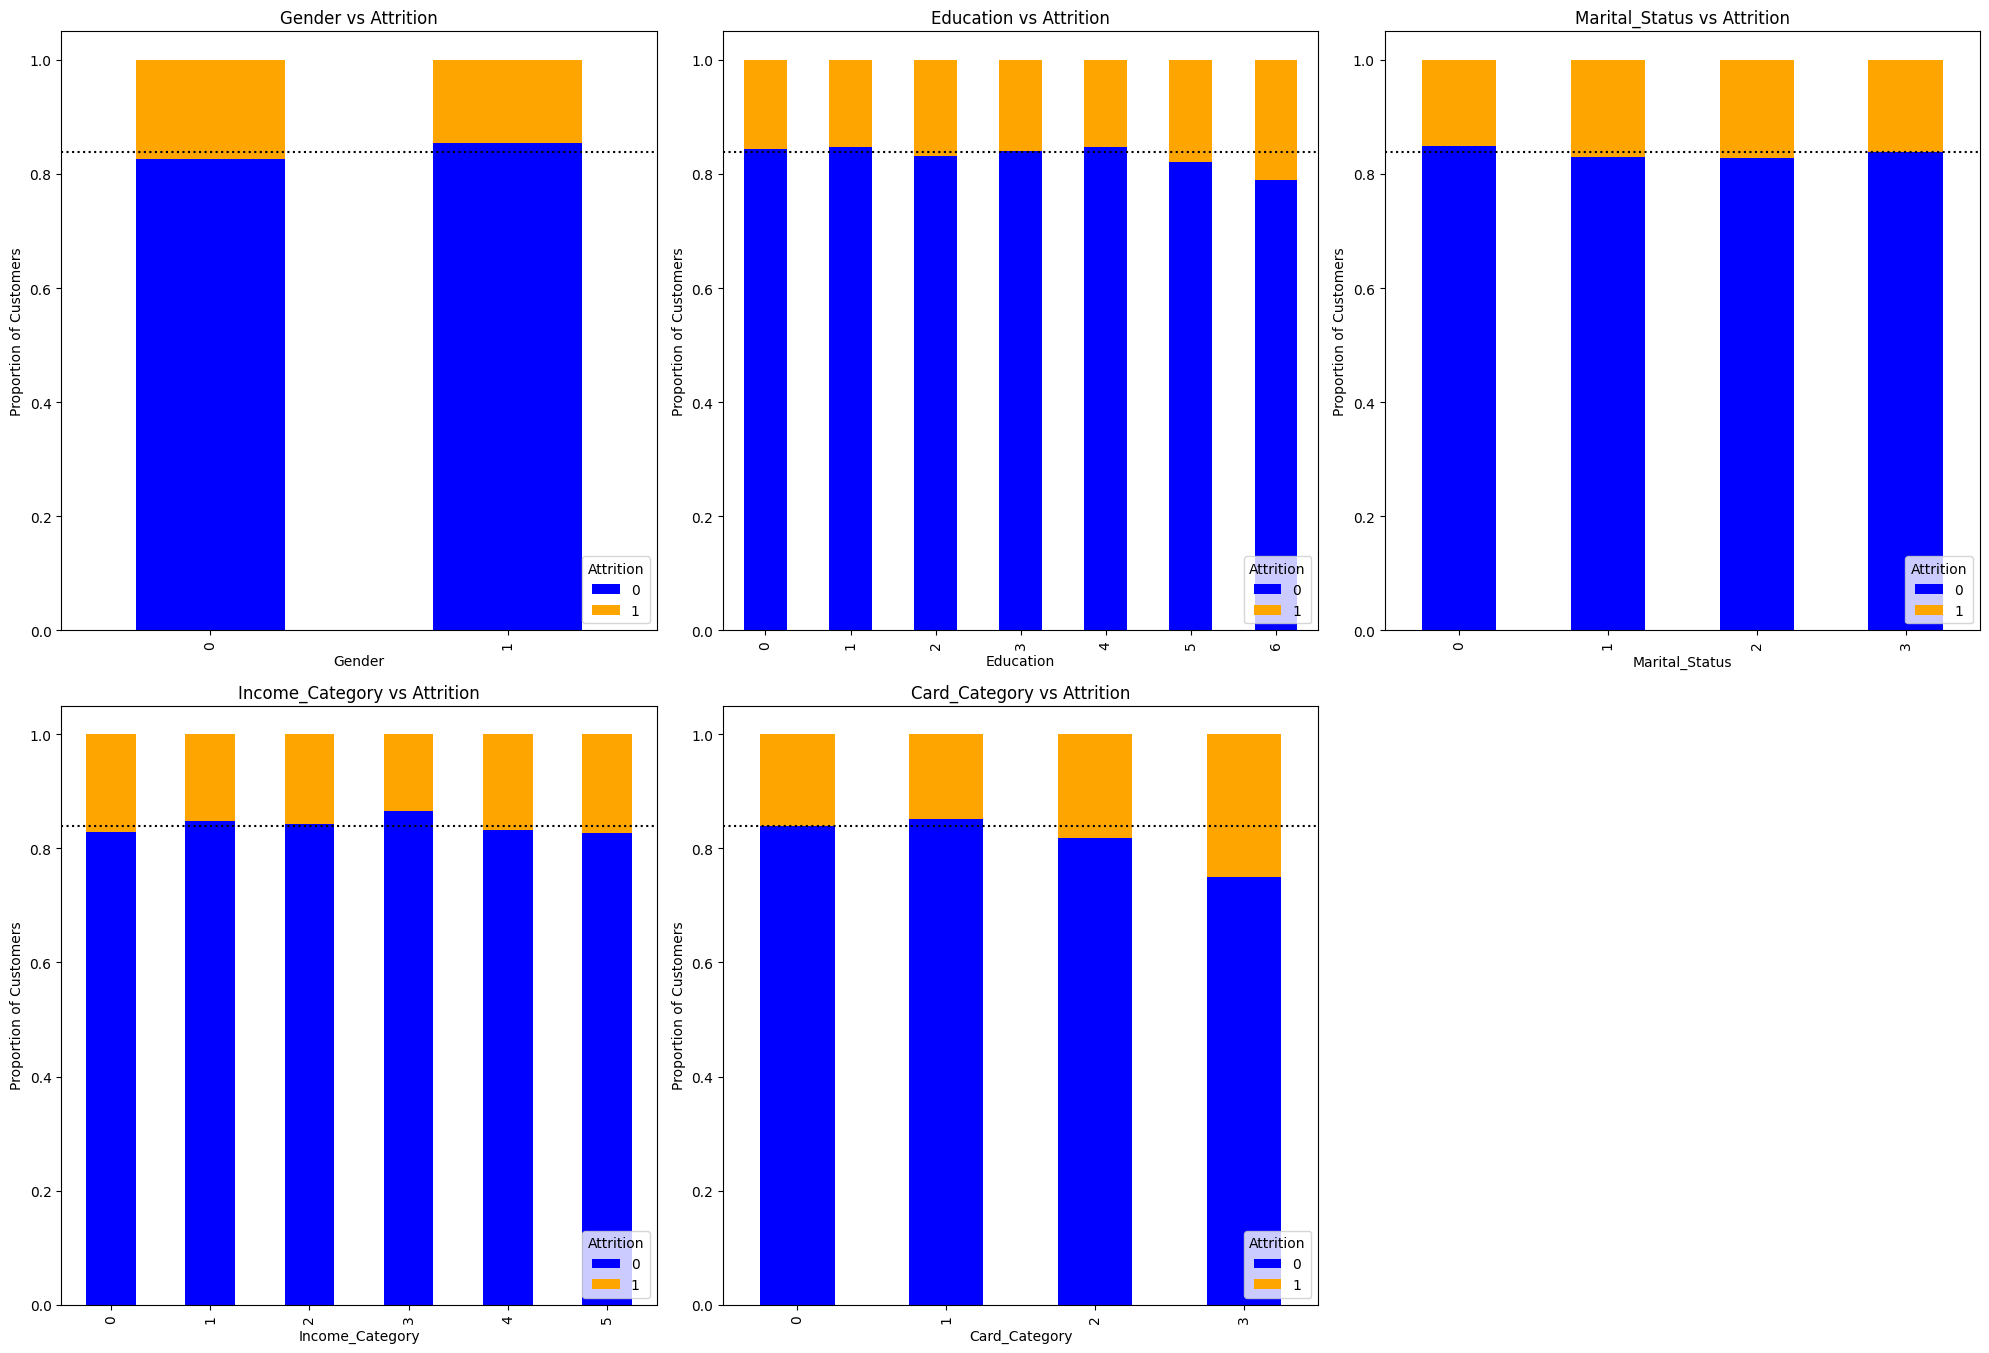

In [340]:
#
categorical_features = ['Gender', 'Education', 'Marital_Status', 'Income_Category', 'Card_Category']

# Set up the plot
plt.figure(figsize=(20, 20))
plot_number = 1
colors = ['blue', 'orange']

# Plot stacked bar charts for categorical features
for feature in categorical_features:
    # Convert PySpark DataFrame columns to Pandas Series
    x = df.select(feature).toPandas()[feature]
    attrition_flag = df.select('Attrition_Flag').toPandas()['Attrition_Flag']
    
    # Create a Pandas DataFrame for crosstab
    table = pd.crosstab(index=x, columns=attrition_flag)
    
    # Normalize to get proportions
    table = table.div(table.sum(1).astype(float), axis=0)
    
    ax = plt.subplot(3, 3, plot_number)
    table.plot(kind='bar', stacked=True, color=colors, ax=ax)
    
    plt.title(f'{feature} vs Attrition')
    plt.ylabel('Proportion of Customers')
    plt.axhline(0.83934, color='black', ls='dotted')  # Baseline: Overall attrition rate
    plt.legend(title='Attrition', loc='lower right')
    
    plot_number += 1

plt.tight_layout()
plt.show()

**Observations:**

- Gender: There are more female that attrited than males.
- Education Level: There are more Doctorate and Post-Grads customers who attrited.
- Marital Status: Those with relationship single and unknown experience more attrition than those who are married or divorced.
- Income Category: Customers in the 60K-80K income bracket have the lowest attrition rate.
- Card Category: Those with premium and gold cardholders have more attrition than blue and silver cardholders

In [341]:
# Select the 'Attrition_Flag' column:
y = df.select('Attrition_Flag')

# Get the number of rows in the DataFrame containing the target variable
num_rows_y = y.count()

print(f"Number of rows in y: {num_rows_y}")

Number of rows in y: 10127


In [342]:
df.show(5)

+---+----------+------+---------+---------------+--------------+------------+-----------------+--------------+----------------+------------+-----------+---------------+---------+--------------+------+---------+--------------+---------------+-------------+
|Age|Dependents|Months|Relations|Inactive_Months|Contacts_Count|Credit_Limit|Revolving_balance|Open_Buy_Ratio|Q4_Q1_Amt_Change|Trans_Amount|Trans_Count|Q4_Q1_Ct_Change|Uti_Ratio|Attrition_Flag|Gender|Education|Marital_Status|Income_Category|Card_Category|
+---+----------+------+---------+---------------+--------------+------------+-----------------+--------------+----------------+------------+-----------+---------------+---------+--------------+------+---------+--------------+---------------+-------------+
| 54|         2|    42|        4|              2|             3|     12217.0|                0|       12217.0|           1.075|        1110|         21|           0.75|      0.0|             0|     1|        2|             0|       

## Train-test split

In [343]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

<b> <font face='Tahoma' color='Yellow' size='5'> DATA TRANSFORMATION

<font color='Yellow'> Encode Categorical variables </font> <font size='5'><b>(VectorAssembler) </font> </b> <br>
VectorAssembler is a feature transformer that Spark provides. VectorAssembler is a useful tool for putting together raw feature columns into a single feature vector column in Spark's machine learning library (MLlib).

In [344]:
# feature column named 'features' and a target column named 'Attrition_Flag'
feature_columns = ['Age','Dependents','Months','Relations','Inactive_Months','Contacts_Count','Credit_Limit',
                                        'Revolving_balance','Open_Buy_Ratio','Q4_Q1_Amt_Change','Trans_Amount','Trans_Count','Q4_Q1_Ct_Change',
                                        'Uti_Ratio','Gender','Education','Marital_Status','Income_Category','Card_Category']

In [345]:

# Assemble features into a vector column
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

### StandardScaler

In [346]:
# StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)

In [347]:
from pyspark.ml import Pipeline

<b><font face='Tahoma' color='Yellow' size='5'> MODEL BUILDING

# Logistic Regression

In [348]:
# Logistic Regression classifier
lr_classifier = LogisticRegression(featuresCol='scaled_features', labelCol='Attrition_Flag', predictionCol='prediction')

In [349]:
# Create a pipeline with assembler, scaler, and classifier stages
pipeline = Pipeline(stages=[assembler, scaler, lr_classifier])

In [350]:
# Train/test split
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

In [351]:
# Fit the pipeline model on the training data
model = pipeline.fit(train_data)

In [352]:
# Make predictions on the test data
predictions = model.transform(test_data)

In [353]:
# Performance Evaluation Metrics
binary_evaluator = BinaryClassificationEvaluator(labelCol='Attrition_Flag')
multi_evaluator = MulticlassClassificationEvaluator(labelCol='Attrition_Flag', metricName='f1')

In [354]:
# ROC AUC
roc_auc = binary_evaluator.evaluate(predictions, {binary_evaluator.metricName: 'areaUnderROC'})
print(f"ROC AUC: {roc_auc}")
# Testing Accuracy
accuracy = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: 'accuracy'})
print(f"Testing Accuracy: {accuracy}")

# Precision
precision = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: 'weightedPrecision'})
print(f"Precision: {precision}")

# Recall
recall = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: 'weightedRecall'})
print(f"Recall: {recall}")

# F1-score
f1_score = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: 'f1'})
print(f"F1-score: {f1_score}")

ROC AUC: 0.9150399290150913
Testing Accuracy: 0.8977389516957862
Precision: 0.8917843257367837
Recall: 0.8977389516957863
F1-score: 0.8926411593225264


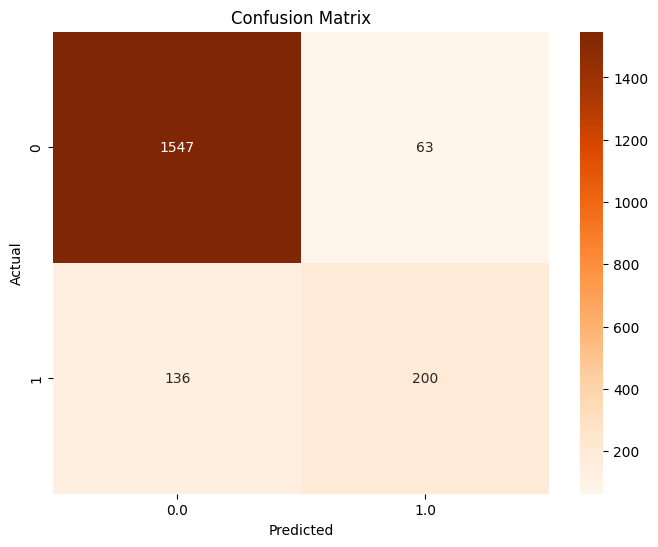

In [355]:
# Convert PySpark DataFrame to Pandas DataFrame
confusion_matrix_pd = predictions.select("Attrition_Flag", "prediction").toPandas()

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(pd.crosstab(confusion_matrix_pd['Attrition_Flag'], confusion_matrix_pd['prediction']),
            annot=True, fmt='d', cmap="Oranges", cbar=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [356]:
# Assuming you have 'assembler' and 'scaler' defined earlier in your code

lr_classifier = LogisticRegression(featuresCol='scaled_features', labelCol='Attrition_Flag', predictionCol='prediction')
pipeline = Pipeline(stages=[assembler, scaler, lr_classifier])

train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)
model = pipeline.fit(train_data)

# Evaluate on train_data
train_predictions = model.transform(train_data)

binary_evaluator_train = BinaryClassificationEvaluator(labelCol='Attrition_Flag')
multi_evaluator_train = MulticlassClassificationEvaluator(labelCol='Attrition_Flag', metricName='f1')

# ROC AUC on train_data
roc_auc_train = binary_evaluator_train.evaluate(train_predictions, {binary_evaluator_train.metricName: 'areaUnderROC'})
print(f"Train ROC AUC: {roc_auc_train}")

# Training Accuracy
accuracy_train = multi_evaluator_train.evaluate(train_predictions, {multi_evaluator_train.metricName: 'accuracy'})
print(f"Training Accuracy: {accuracy_train}")

# Precision on train_data
precision_train = multi_evaluator_train.evaluate(train_predictions, {multi_evaluator_train.metricName: 'weightedPrecision'})
print(f"Train Precision: {precision_train}")

# Recall on train_data
recall_train = multi_evaluator_train.evaluate(train_predictions, {multi_evaluator_train.metricName: 'weightedRecall'})
print(f"Train Recall: {recall_train}")

# F1-score on train_data
f1_score_train = multi_evaluator_train.evaluate(train_predictions, {multi_evaluator_train.metricName: 'f1'})
print(f"Train F1-score: {f1_score_train}")

Train ROC AUC: 0.9264566345774382
Training Accuracy: 0.9069795868475736
Train Precision: 0.9011204961796584
Train Recall: 0.9069795868475736
Train F1-score: 0.9017567727183561


## Decision Tree classifier

In [357]:
# Decision Tree classifier
dt_classifier = DecisionTreeClassifier(featuresCol='scaled_features', labelCol='Attrition_Flag', predictionCol='prediction')

# Create a pipeline with assembler, scaler, and classifier stages
pipeline = Pipeline(stages=[assembler, scaler, dt_classifier])

# Train/test split
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# Fit the pipeline model on the training data
model = pipeline.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Performance Evaluation Metrics
binary_evaluator = BinaryClassificationEvaluator(labelCol='Attrition_Flag')
multi_evaluator = MulticlassClassificationEvaluator(labelCol='Attrition_Flag', metricName='f1')

# ROC AUC
roc_auc = binary_evaluator.evaluate(predictions, {binary_evaluator.metricName: 'areaUnderROC'})
print(f"ROC AUC: {roc_auc}")

# Testing Accuracy
accuracy = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: 'accuracy'})
print(f"Testing Accuracy: {accuracy}")

# Precision
precision = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: 'weightedPrecision'})
print(f"Precision: {precision}")

# Recall
recall = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: 'weightedRecall'})
print(f"Recall: {recall}")

# F1-score
f1_score = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: 'f1'})
print(f"F1-score: {f1_score}")

ROC AUC: 0.8909087548062705
Testing Accuracy: 0.9177800616649537
Precision: 0.9166986180886775
Recall: 0.9177800616649537
F1-score: 0.9171852437042265


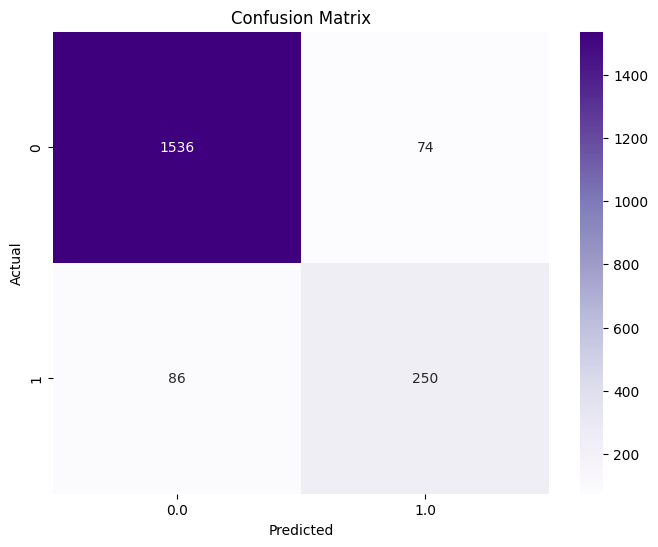

In [358]:
confusion_matrixLG = predictions.select("Attrition_Flag", "prediction").toPandas()

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(pd.crosstab(confusion_matrixLG['Attrition_Flag'], confusion_matrixLG['prediction']),
            annot=True, fmt='d', cmap="Purples", cbar=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Model Evaluation Table

 The code compares the performance of a Logistic Regression model and a Decision Tree model on a binary classification task using a dataset with various features. The code begins by preparing the data, including assembling the feature vector. It then splits the data into training and testing sets. Subsequently, two machine learning pipelines are constructed—one for Logistic Regression and another for Decision Tree each comprising a feature assembler and the respective classifier. The models are trained on the training data, and predictions are generated on the test data. <br>

For the evaluation, the code employs various metrics, including ROC AUC, Testing Accuracy, Precision, Recall, and F1-Score. These metrics provide a comprehensive assessment of the models' performance. BinaryClassificationEvaluator is used for ROC AUC, while MulticlassClassificationEvaluator is employed for the remaining metrics. The evaluations are stored in a Pandas DataFrame for convenient comparison. The resulting table summarizes the performance of both models across the selected metrics, offering insights into their effectiveness in predicting the binary target variable (Attrition_Flag). The user can customize the feature columns, models, and evaluation metrics based on their specific use case and requirements.

In [359]:
# Logistic Regression
lr_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
lr_scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
lr_model = LogisticRegression(featuresCol='scaled_features', labelCol='Attrition_Flag', predictionCol='prediction')
lr_pipeline = Pipeline(stages=[lr_assembler, lr_scaler, lr_model])
lr_model = lr_pipeline.fit(train_data)
lr_predictions = lr_model.transform(test_data)

# Decision Tree
dt_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
dt_scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
dt_model = DecisionTreeClassifier(featuresCol='scaled_features', labelCol='Attrition_Flag', predictionCol='prediction')
dt_pipeline = Pipeline(stages=[dt_assembler, dt_scaler, dt_model])
dt_model = dt_pipeline.fit(train_data)
dt_predictions = dt_model.transform(test_data)

# Performance Evaluation Metrics
binary_evaluator = BinaryClassificationEvaluator(labelCol='Attrition_Flag')
multi_evaluator = MulticlassClassificationEvaluator(labelCol='Attrition_Flag', metricName='f1')

# Create a dictionary to store the results
results = {
    'Model': ['Logistic Regression', 'Decision Tree'],
    'ROC AUC': [
        binary_evaluator.evaluate(lr_predictions, {binary_evaluator.metricName: 'areaUnderROC'}),
        binary_evaluator.evaluate(dt_predictions, {binary_evaluator.metricName: 'areaUnderROC'})
    ],
    'Testing Accuracy': [
        multi_evaluator.evaluate(lr_predictions, {multi_evaluator.metricName: 'accuracy'}),
        multi_evaluator.evaluate(dt_predictions, {multi_evaluator.metricName: 'accuracy'})
    ],
    'Precision': [
        multi_evaluator.evaluate(lr_predictions, {multi_evaluator.metricName: 'weightedPrecision'}),
        multi_evaluator.evaluate(dt_predictions, {multi_evaluator.metricName: 'weightedPrecision'})
    ],
    'Recall': [
        multi_evaluator.evaluate(lr_predictions, {multi_evaluator.metricName: 'weightedRecall'}),
        multi_evaluator.evaluate(dt_predictions, {multi_evaluator.metricName: 'weightedRecall'})
    ],
    'F1-Score': [
        multi_evaluator.evaluate(lr_predictions, {multi_evaluator.metricName: 'f1'}),
        multi_evaluator.evaluate(dt_predictions, {multi_evaluator.metricName: 'f1'})
    ]
}

# Create a Pandas DataFrame
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

                 Model   ROC AUC  Testing Accuracy  Precision    Recall  \
0  Logistic Regression  0.915040          0.897739   0.891784  0.897739   
1        Decision Tree  0.890909          0.917780   0.916699  0.917780   

   F1-Score  
0  0.892641  
1  0.917185  


## Conclusion

<font color='Yellow'>ROC AUC:<br></font>
&#x2022;Logistic Regression: 0.915040 <br>
&#x2022;Decision Tree: 0.890909 <br>

<font color='Yellow'>Testing Accuracy:<br></font>
&#x2022;Logistic Regression: 0.897739<br>
&#x2022;Decision Tree: 0.917780<br>

<font color='Yellow'>Precision:<br></font>
&#x2022;Logistic Regression: 0.891784<br>
&#x2022;Decision Tree: 0.916699<br>

<font color='Yellow'>Recall:<br></font>
&#x2022;Logistic Regression: 0.897739<br>
&#x2022;Decision Tree: 0.917780<br>

<font color='Yellow'>F1-Score:<br></font>
&#x2022;Logistic Regression: 0.892641 <br>
&#x2022;Decision Tree: 0.917185 <br>

We choose <b><font color='Yellow'>Decision Tree model </font> over Logistic regression <br><br></b> <i>
Overall, both models do well across all metrics, but the Decision Tree model has slightly better Testing Accuracy, Precision, Recall, and F1-Score than the Logistic Regression model. The Logistic Regression model, on the other hand, has a slightly higher ROC AUC.

You should choose between the two models based on the application's goals and needs. The <font color='Yellow'> Decision Tree model </font> is the best choice if we want to make predictions that are accurate overall and have a good balance between precision and recall. But if getting a large area under the ROC curve is very important, the Logistic Regression model might be better.

When choosing the best fit for the dataset, it's best to think about the application's specifics, how important false positives and false negatives are, and how easy it is to understand the models. It is also possible to do more research or experiments to improve the models and see how stable they are.

![separator1](https://i.imgur.com/RQnsV0w.png)

<CENTER> <FONT SIZE='6'> END